# <center> Segmenting and Clustering Neighborhoods in Austin</center>

## <center>Viktoriia Slaikovskaia</center>
## <center> July 2020</center>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Exploring Austin</a>

2. <a href="#item2">Crime data set</a>
    <br>2.1 <a href="#item21"> Clean data </a>
    <br>2.2 <a href="#item22"> Adding neighborhoods to crime data </a>
    <br>2.3 <a href="#item23"> Analyze neighborhoods </a>
    <br>2.3.1 <a href="#item231"> Crimes after dark </a>
    <br>2.3.2 <a href="#item232"> Family violence </a>
    <br>2.3.3 <a href="#item233"> Part I offenses </a>
    <br>2.3.4 <a href="#item234"> Binning severe crime data</a>

3. <a href="#item3">Rent data set</a>
    <br>3.1 <a href="#item31"> Analysis </a>
    <br>3.2 <a href="#item32"> Binning median rate data </a>
    
4. <a href="#item4">Venues data set</a>
    <br>4.1 <a href="#item41"> Extract categories </a>
    <br>4.2 <a href="#item42"> Cluster venues data frame </a>
    <br>4.3 <a href="#item43"> Cluster venues data </a>
    <br>4.4 <a href="#item44"> Wordcloude visualization </a>
    <br>4.5 <a href="#item45"> Name clusters </a>

5. <a href="#item5">Cluster Neighborhoods</a>
    <br>5.1 <a href="#item51">Choosing number of clusters</a>
    <br>5.2 <a href="#item52">K-mean clustering</a>
    <br>5.3 <a href="#item53">Examine Clusters</a>    
</font>
</div>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import folium
import wget
import geocoder
import pgeocode
import html
import requests
import configparser
import swifter

from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from statistics import median
from shapely.geometry import Point
from geopandas import GeoSeries
from wordcloud import WordCloud
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

pd.set_option('display.max_rows', 110)
pd.set_option('display.max_columns', 500)

### The data used for this project:
#### Criminal reports from Austin police department at https://www.austintexas.gov/department/crime-information
#### Foursquare venues data
#### Scratched rent data from popular site

<a id='item1'></a>

 # 1. Exploring Austin
 
Let's start by creating the Austin map.
First that we need latitude and longitude.

In [2]:
g = geocoder.osm('Austin, TX')
location = g.latlng

In [3]:
austin_map = folium.Map(location=g.latlng, zoom_start=12)

In [4]:
austin_map

### For the neighborhood map, we need a geojson, which we could find at GitHub.
geojson was taken from https://github.com/codeforamerica/click_that_hood/blob/master/public/data/austin.geojson

In [5]:
ngh = gpd.read_file('austin.geojson')
ngh_names = ngh['name']

In [6]:
ngh_names.head()

0        Blackland
1    Bouldin Creek
2        Brentwood
3       Cherrywood
4         Chestnut
Name: name, dtype: object

In [7]:
geometry = ngh['geometry']
geometry.head()

0    MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...
1    MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...
2    MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...
3    MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...
4    MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...
Name: geometry, dtype: geometry

#### We will need centers in every neighborhood.  

In [8]:
centroids_longtitude = ngh['geometry'].centroid.x
centroids_latitude = ngh['geometry'].centroid.y

In [9]:
data = {'geometry': geometry, 'name': ngh_names, 'latitude': centroids_latitude, 'longtitude': centroids_longtitude}
neigh = pd.DataFrame(data)

In [10]:
neigh.head()

geometry           name  \
0  MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...      Blackland   
1  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...  Bouldin Creek   
2  MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...      Brentwood   
3  MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...     Cherrywood   
4  MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...       Chestnut   

    latitude  longtitude  
0  30.281794  -97.721684  
1  30.251705  -97.755626  
2  30.330625  -97.732451  
3  30.290292  -97.715019  
4  30.277860  -97.715049

### Create a map of neighborhoods.

In [11]:
m = folium.Map(location=[30.2711286, -97.7436995], zoom_start=12)

## add chloropleth layer
m.choropleth(
    geo_data='austin.geojson',
    name='Neighbourhoods',
    fill_color='pink',
    fill_opacity=0.3, 
    line_opacity=0.2,
)  

latitudes = list(neigh['latitude'])
longitudes = list(neigh['longtitude'])
labels = list(neigh['name'])

# add markers 
for lat, lon, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lon], popup=folium.Popup(html.escape(label))).add_to(m)
    
# enable layers to be turned in or out
folium.LayerControl().add_to(m)
m

<a id='item2'></a>


# 2. Crime data set

### Read crime report data, which was download in advance from the Austin TX government site.

In [ ]:
crime = pd.read_csv('Crime_Reports.csv')

In [13]:
crime.head()

Incident Number     Highest Offense Description  Highest Offense Code  \
0      20125003262                PROTECTIVE ORDER                  3829   
1      20072832112             ASSAULT WITH INJURY                   900   
2      20081232700              FAMILY DISTURBANCE                  3400   
3       2006900236             ASSAULT WITH INJURY                   900   
4      20081002040  CRASH/FAIL STOP AND RENDER AID                  3604   

  Family Violence      Occurred Date Time Occurred Date  Occurred Time  \
0               N  01/23/2012 05:17:00 AM    01/23/2012          517.0   
1               N  10/10/2007 09:00:00 PM    10/10/2007         2100.0   
2               N  05/02/2008 11:11:00 PM    05/02/2008         2311.0   
3               N  03/31/2006 02:50:00 AM    03/31/2006          250.0   
4               N  04/09/2008 07:04:00 PM    04/09/2008         1904.0   

         Report Date Time Report Date  Report Time  \
0  01/23/2012 05:17:00 AM  01/23/2012        517.0   
1  10/10/2007 10:00:00 PM  10/10/2007       2200.0   
2  05/02/2008 11:11:00 PM  05/02/2008       2311.0   
3  03/31/2006 02:50:00 AM  03/31/2006        250.0   
4  04/09/2008 09:08:00 PM  04/09/2008       2108.0   

                  Location Type                               Address  \
0              RESIDENCE / HOME                               UNKNOWN   
1              BAR / NIGHT CLUB  HOT BODIES CLUB HWY 71 & BURLESON RD   
2              RESIDENCE / HOME                    9702 CHILSOM TRAIL   
3              RESIDENCE / HOME                       721 LAMAR PLACE   
4  STREETS / HWY / ROAD / ALLEY               2500 BLOCK OF GUADALUPE   

   Zip Code  Council District APD Sector APD District  PRA  Census Tract  \
0       NaN               NaN         DA            1  491           NaN   
1       NaN               NaN        NaN          NaN  NaN           NaN   
2       NaN               NaN        NaN          NaN  NaN           NaN   
3       NaN               NaN        NaN          NaN  NaN           NaN   
4       NaN               NaN        NaN          NaN  NaN           NaN   

  Clearance Status Clearance Date UCR Category Category Description  \
0                N     01/23/2012          NaN                  NaN   
1              NaN            NaN          NaN                  NaN   
2              NaN            NaN          NaN                  NaN   
3              NaN            NaN          NaN                  NaN   
4                N     12/16/2008          NaN                  NaN   

   X-coordinate  Y-coordinate  Latitude  Longitude Location  
0           NaN           NaN       NaN        NaN      NaN  
1           NaN           NaN       NaN        NaN      NaN  
2           NaN           NaN       NaN        NaN      NaN  
3           NaN           NaN       NaN        NaN      NaN  
4           NaN           NaN       NaN        NaN      NaN

<a id='item21'></a>

## 2.1 Clean data
### Drop columns we do not need

##### Incident Number - we do not need this one because we have pandas unique index.
##### Occurred Date Time, Report Date Time - columns with the date and time apart is enough.
##### APD Sector, APD District, PRA - not informative for us, because we need only neighborhood data.
##### Clearance Status, Clearance Date - occurred date is enough.
##### Address, Zip Code, Council District, Census Tract, X-coordinate, Y-coordinate - latitude, and longitude is pretty enough for our purposes.

In [14]:
crime.drop(['Incident Number',
                'Report Date Time',
                'Occurred Date Time',
                'APD Sector',
                'APD District',
                'Clearance Status',
                'Clearance Date',
                'PRA',
                'Address',
                'Zip Code',
                'Council District',
                'Census Tract',
                'X-coordinate',
                'Y-coordinate'],
               axis = 1, inplace=True)

In [15]:
crime.tail(10)

Highest Offense Description  Highest Offense Code Family Violence  \
2242718                      AUTO THEFT                   700               N   
2242719              FAMILY DISTURBANCE                  3400               N   
2242720               CRIMINAL MISCHIEF                  1400               N   
2242721     VOCO - ALCOHOL  CONSUMPTION                  3211               N   
2242722                             DWI                  2100               N   
2242723  ASSAULT W/INJURY-FAM/DATE VIOL                   900               Y   
2242724               CRIMINAL TRESPASS                  2716               N   
2242725                   RUNAWAY CHILD                  4100               N   
2242726                             DWI                  2100               N   
2242727             PUBLIC INTOXICATION                  2300               N   

        Occurred Date  Occurred Time Report Date  Report Time  \
2242718    02/18/2010         1338.0  02/18/2010       1338.0   
2242719    01/23/2010         2244.0  01/24/2010         14.0   
2242720    10/18/2003         2000.0  10/19/2003        153.0   
2242721    08/15/2009           45.0  08/15/2009         45.0   
2242722    10/23/2008            1.0  10/23/2008          1.0   
2242723    03/04/2010         2001.0  03/04/2010       2001.0   
2242724    08/24/2017         2027.0  08/24/2017       2127.0   
2242725    02/23/2014         1950.0  02/23/2014       2228.0   
2242726    09/12/2005         2357.0  09/12/2005       2357.0   
2242727    06/10/2010          229.0  06/10/2010        229.0   

                        Location Type UCR Category Category Description  \
2242718          HOTEL / MOTEL / ETC.          240           Auto Theft   
2242719              RESIDENCE / HOME          NaN                  NaN   
2242720              RESIDENCE / HOME          NaN                  NaN   
2242721  STREETS / HWY / ROAD / ALLEY          NaN                  NaN   
2242722  STREETS / HWY / ROAD / ALLEY          NaN                  NaN   
2242723  STREETS / HWY / ROAD / ALLEY          NaN                  NaN   
2242724                   RESTAURANTS          NaN                  NaN   
2242725              RESIDENCE / HOME          NaN                  NaN   
2242726         PARKING LOTS / GARAGE          NaN                  NaN   
2242727  STREETS / HWY / ROAD / ALLEY          NaN                  NaN   

          Latitude  Longitude                     Location  
2242718  30.346018 -97.696670   (30.3460179, -97.69666986)  
2242719  30.360317 -97.693437  (30.36031662, -97.69343723)  
2242720  30.394107 -97.671280  (30.39410654, -97.67128031)  
2242721  30.267184 -97.739377   (30.2671839, -97.73937664)  
2242722  30.240890 -97.730260  (30.24089004, -97.73026008)  
2242723  30.266225 -97.747311   (30.2662249, -97.74731088)  
2242724  30.239289 -97.719831  (30.23928876, -97.71983119)  
2242725  30.230056 -97.771030    (30.2300562, -97.7710298)  
2242726  30.334253 -97.741086  (30.33425261, -97.74108649)  
2242727  30.265775 -97.734038   (30.2657748, -97.73403764)

In [16]:
crime.shape

(2242728, 13)

### Change data types

In [17]:
crime.dtypes

Highest Offense Description     object
Highest Offense Code             int64
Family Violence                 object
Occurred Date                   object
Occurred Time                  float64
Report Date                     object
Report Time                    float64
Location Type                   object
UCR Category                    object
Category Description            object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

#### As we can see, not every column has a correct data type.
For example, date and time should be at daytime type.

In [18]:
crime['Report Date'] = pd.to_datetime(crime['Report Date'])
crime['Occurred Date'] = pd.to_datetime(crime['Occurred Date'])

In [19]:
crime.dtypes

Highest Offense Description            object
Highest Offense Code                    int64
Family Violence                        object
Occurred Date                  datetime64[ns]
Occurred Time                         float64
Report Date                    datetime64[ns]
Report Time                           float64
Location Type                          object
UCR Category                           object
Category Description                   object
Latitude                              float64
Longitude                             float64
Location                               object
dtype: object

### The crime report consists of massive data from too many years, so better to cut data set and leave reports after the 2015 year.

In [20]:
crime = crime.loc[crime['Report Date'] > '2014-12-31']

In [21]:
crime.shape

(594803, 13)

## Clear missing important values

#### As we need to know where the crime happened, we need to know coordinates data—so right decision to drop rows without longitude and latitude.

In [22]:
crime.dropna(subset = ['Latitude', 'Longitude'], inplace=True)

In [23]:
crime.shape

(582564, 13)

<a id='item22'></a>

# 2.2 Adding neighborhoods to crime data

In [24]:
geometry.head()

0    MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...
1    MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...
2    MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...
3    MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...
4    MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...
Name: geometry, dtype: geometry

### Function for finding the name of a neighborhood by location.

#### We will need to create a point with a crime coordinate and check if any of these areas contain this point.

In [25]:
def findIndex(lat, long, ngh):
    p = Point(long, lat)
    try:
        return neigh[ngh.contains(p)].loc[:, 'name'].to_numpy()[0]
    except IndexError:
        return np.nan

In [26]:
findIndex(30.251705,-97.755626, geometry)

'Bouldin Creek'

In [27]:
findIndex(30.281794, -97.721684, geometry)

'Blackland'

### We are adding a new empty column to crime data.

In [28]:
crime.loc[:, 'Neigbourhood' ] = np.nan

In [29]:
crime.head()

Highest Offense Description  Highest Offense Code Family Violence  \
108                  HARASSMENT                  2703               N   
127             THEFT FROM AUTO                   603               N   
162                  AUTO THEFT                   700               N   
164  WARRANT ARREST NON TRAFFIC                  3442               N   
182    VIOL OF PROTECTIVE ORDER                  3009               N   

    Occurred Date  Occurred Time Report Date  Report Time  \
108    2016-12-19            0.0  2017-01-19       1528.0   
127    2016-08-12          730.0  2016-08-12       1503.0   
162    2017-12-02         1817.0  2017-12-02       2146.0   
164    2016-07-21         2322.0  2016-07-21       2322.0   
182    2018-09-25          153.0  2018-09-25        153.0   

                    Location Type UCR Category Category Description  \
108              RESIDENCE / HOME          NaN                  NaN   
127         PARKING LOTS / GARAGE          23F                Theft   
162              RESIDENCE / HOME          240           Auto Theft   
164  STREETS / HWY / ROAD / ALLEY          NaN                  NaN   
182              RESIDENCE / HOME          NaN                  NaN   

      Latitude  Longitude                     Location  Neigbourhood  
108  30.255923 -97.779322  (30.25592347, -97.77932175)           NaN  
127  30.321278 -97.718254    (30.32127758, -97.718254)           NaN  
162  30.178412 -97.827780  (30.17841216, -97.82778042)           NaN  
164  30.224670 -97.804474  (30.22467025, -97.80447442)           NaN  
182  30.329229 -97.698625  (30.32922856, -97.69862519)           NaN

In [30]:
crime.reset_index(drop=True, inplace = True)

In [31]:
crime['Neigbourhood'].isna().value_counts()

True    582564
Name: Neigbourhood, dtype: int64

##  Changing the Neighbourhood column.

### Create points for every location from crime data

In [32]:
def make_point(r):
    return Point(r.Longitude, r.Latitude)

points = gpd.GeoSeries(crime.loc[:, ("Longitude", "Latitude")].swifter.apply(make_point, axis=1))

In [33]:
for i in np.arange(geometry.shape[0]):
    crime.loc[points.within(geometry.iloc[i]), "Neigbourhood"] = neigh.loc[i, "name"]

In [34]:
crime['Neigbourhood'].isna().value_counts()

False    406687
True     175877
Name: Neigbourhood, dtype: int64

## As we can see here, not every crime happened to be in Austin.
#### Reduce all crimes outside Austin.

In [35]:
crime = crime[crime["Neigbourhood"].notna()]

In [36]:
crime.head()

Highest Offense Description  Highest Offense Code Family Violence  \
0                  HARASSMENT                  2703               N   
1             THEFT FROM AUTO                   603               N   
3  WARRANT ARREST NON TRAFFIC                  3442               N   
4    VIOL OF PROTECTIVE ORDER                  3009               N   
6                         DWI                  2100               N   

  Occurred Date  Occurred Time Report Date  Report Time  \
0    2016-12-19            0.0  2017-01-19       1528.0   
1    2016-08-12          730.0  2016-08-12       1503.0   
3    2016-07-21         2322.0  2016-07-21       2322.0   
4    2018-09-25          153.0  2018-09-25        153.0   
6    2019-07-06          328.0  2019-07-06        708.0   

                  Location Type UCR Category Category Description   Latitude  \
0              RESIDENCE / HOME          NaN                  NaN  30.255923   
1         PARKING LOTS / GARAGE          23F                Theft  30.321278   
3  STREETS / HWY / ROAD / ALLEY          NaN                  NaN  30.224670   
4              RESIDENCE / HOME          NaN                  NaN  30.329229   
6  STREETS / HWY / ROAD / ALLEY          NaN                  NaN  30.233876   

   Longitude                     Location         Neigbourhood  
0 -97.779322  (30.25592347, -97.77932175)         Barton Hills  
1 -97.718254    (30.32127758, -97.718254)  North Loop/Ridgetop  
3 -97.804474  (30.22467025, -97.80447442)            West Gate  
4 -97.698625  (30.32922856, -97.69862519)           St. John's  
6 -97.715765  (30.23387556, -97.71576502)      Pleasant Valley

In [37]:
crime.reset_index(drop=True, inplace = True)

In [38]:
crime.head(7)

Highest Offense Description  Highest Offense Code Family Violence  \
0                  HARASSMENT                  2703               N   
1             THEFT FROM AUTO                   603               N   
2  WARRANT ARREST NON TRAFFIC                  3442               N   
3    VIOL OF PROTECTIVE ORDER                  3009               N   
4                         DWI                  2100               N   
5         FAILURE TO IDENTIFY                  2707               N   
6         BURGLARY OF VEHICLE                   601               N   

  Occurred Date  Occurred Time Report Date  Report Time  \
0    2016-12-19            0.0  2017-01-19       1528.0   
1    2016-08-12          730.0  2016-08-12       1503.0   
2    2016-07-21         2322.0  2016-07-21       2322.0   
3    2018-09-25          153.0  2018-09-25        153.0   
4    2019-07-06          328.0  2019-07-06        708.0   
5    2017-02-14         1216.0  2017-02-14       1236.0   
6    2020-03-06          330.0  2020-03-08       1022.0   

                  Location Type UCR Category Category Description   Latitude  \
0              RESIDENCE / HOME          NaN                  NaN  30.255923   
1         PARKING LOTS / GARAGE          23F                Theft  30.321278   
2  STREETS / HWY / ROAD / ALLEY          NaN                  NaN  30.224670   
3              RESIDENCE / HOME          NaN                  NaN  30.329229   
4  STREETS / HWY / ROAD / ALLEY          NaN                  NaN  30.233876   
5  STREETS / HWY / ROAD / ALLEY          NaN                  NaN  30.271772   
6               OTHER / UNKNOWN          23F                Theft  30.232921   

   Longitude                     Location         Neigbourhood  
0 -97.779322  (30.25592347, -97.77932175)         Barton Hills  
1 -97.718254    (30.32127758, -97.718254)  North Loop/Ridgetop  
2 -97.804474  (30.22467025, -97.80447442)            West Gate  
3 -97.698625  (30.32922856, -97.69862519)           St. John's  
4 -97.715765  (30.23387556, -97.71576502)      Pleasant Valley  
5 -97.695998   (30.2717716, -97.69599798)          Oak Springs  
6 -97.737399  (30.23292142, -97.73739875)            Riverside

<a id='item23'></a>

## 2.3 Analyze neighborhoods
#### How many crimes happened to be by every neighborhood.

In [39]:
crime_numbers = crime['Neigbourhood'].value_counts().to_frame(name="count")

In [40]:
crime_numbers.head()

count
Downtown         44258
North Austin     25492
Riverside        16541
Windsor Park     16159
Pleasant Valley  11925

## Top 10 neighborhoods with fewer crimes

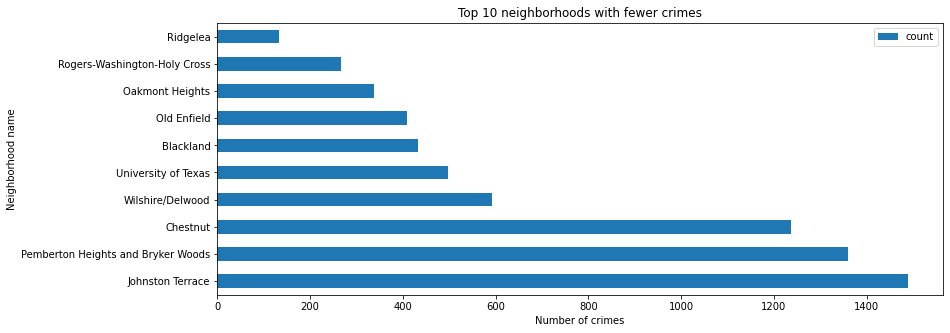

In [41]:
crime_numbers.tail(10).plot(kind='barh', figsize=(13, 5))

plt.title('Top 10 neighborhoods with fewer crimes')
plt.xlabel('Number of crimes')
plt.ylabel('Neighborhood name')

plt.show()

## Top 10 less safest neighborhood

In [42]:
crime_numbers.sort_values(by='count', ascending = True, inplace = True)
df_top10 = crime_numbers['count'].tail(10)

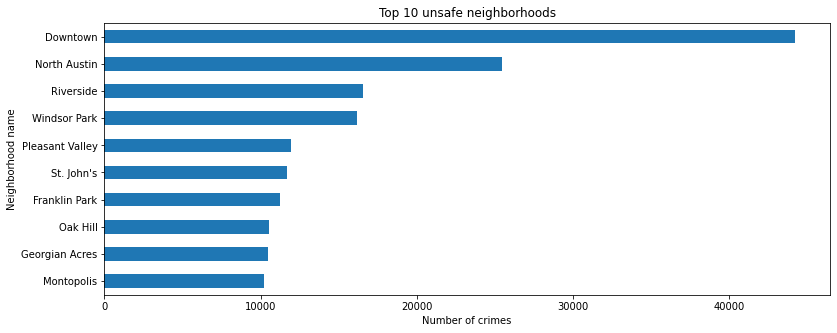

In [43]:
df_top10.plot(kind='barh', figsize=(13, 5))

plt.title('Top 10 unsafe neighborhoods')
plt.xlabel('Number of crimes')
plt.ylabel('Neighborhood name')

plt.show()

In [44]:
crime_numbers = crime_numbers.reset_index()

In [45]:
cn = folium.Map(location=[30.2711286, -97.7436995], zoom_start=12)

cn.choropleth(
    geo_data=r'austin.geojson',
    name='All crimes',
    data=crime_numbers,
    columns=['index', 'count'],
    fill_color='YlOrRd',
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Number of crimes',
    key_on= 'feature.properties.name',
)  

cn

<a id='item231'></a>

## 2.3.1 Crimes after 20:00 to 6:00
#### It is good to know which neighborhood to avoid at night—the number of crimes at night showing nightlife area in the city.

In [46]:
after_eight = crime.loc[crime['Occurred Time'] > 2000]
before_six = crime.loc[crime['Occurred Time'] < 600]

In [47]:
after_eight.shape

(86615, 14)

In [48]:
before_six.shape

(84168, 14)

In [49]:
night = [after_eight, before_six]

In [50]:
night = pd.concat(night)

In [51]:
night.head()

Highest Offense Description  Highest Offense Code Family Violence  \
2    WARRANT ARREST NON TRAFFIC                  3442               N   
7            FAMILY DISTURBANCE                  3400               N   
12          PUBLIC INTOXICATION                  2300               N   
15                RUNAWAY CHILD                  4100               N   
16  BURGLARY OF COIN-OP MACHINE                   602               N   

   Occurred Date  Occurred Time Report Date  Report Time  \
2     2016-07-21         2322.0  2016-07-21       2322.0   
7     2017-12-19         2200.0  2017-12-19       2200.0   
12    2019-09-01         2138.0  2019-09-01       2251.0   
15    2018-04-21         2230.0  2018-04-24       1213.0   
16    2015-04-16         2300.0  2015-04-17        202.0   

                   Location Type UCR Category Category Description   Latitude  \
2   STREETS / HWY / ROAD / ALLEY          NaN                  NaN  30.224670   
7               RESIDENCE / HOME          NaN                  NaN  30.233303   
12         PARKING LOTS / GARAGE          NaN                  NaN  30.383932   
15              RESIDENCE / HOME          NaN                  NaN  30.241843   
16          HOTEL / MOTEL / ETC.          23E                Theft  30.375419   

    Longitude                     Location   Neigbourhood  
2  -97.804474  (30.22467025, -97.80447442)      West Gate  
7  -97.776198   (30.2333031, -97.77619831)    South Lamar  
12 -97.712247  (30.38393202, -97.71224676)   North Austin  
15 -97.757543   (30.24184309, -97.7575428)  Bouldin Creek  
16 -97.676900  (30.37541859, -97.67690009)    North Lamar

In [52]:
night_crimes = night['Neigbourhood'].value_counts().to_frame(name="count")

In [53]:
night_crimes.head()

count
Downtown         23679
North Austin     10833
Riverside         7170
Windsor Park      6284
Pleasant Valley   5333

In [54]:
night_crimes.sort_values(by='count', ascending = True, inplace = True)
night_crimes_top10 = night_crimes.tail(10)

night_crimes_top10

count
Parker Lane       3906
Montopolis        4134
Georgian Acres    4838
Franklin Park     5101
St. John's        5313
Pleasant Valley   5333
Windsor Park      6284
Riverside         7170
North Austin     10833
Downtown         23679

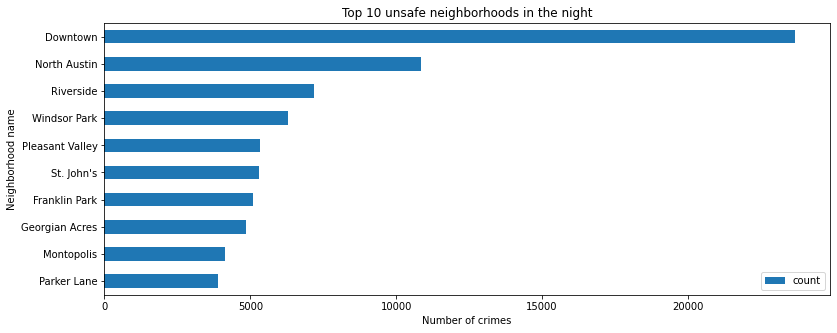

In [55]:
night_crimes_top10.plot(kind='barh', figsize=(13, 5))

plt.title('Top 10 unsafe neighborhoods in the night')
plt.xlabel('Number of crimes')
plt.ylabel('Neighborhood name')

plt.show()

In [56]:
night_crimes = night_crimes.reset_index()

In [57]:
nc = folium.Map(location=[30.2711286, -97.7436995], zoom_start=12)

nc.choropleth(
    geo_data=r'austin.geojson',
    name='Neighbourhoods',
    data=night_crimes,
    columns=['index', 'count'],
    fill_color='YlOrRd',
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Number of crimes',
    key_on= 'feature.properties.name',
)  

nc

### As we can see, Downtown has a vast number of crimes at night. We could consider that life after dark here is not stopping and even dangerous to stay longer.

<a id='item232'></a>

## 2.3.2 Family violence

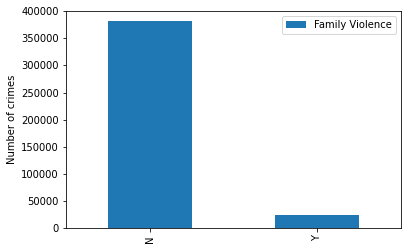

In [58]:
crime['Family Violence'].value_counts().to_frame().plot(kind='bar')

plt.ylabel('Number of crimes')

plt.show()

In [59]:
family = crime.loc[crime['Family Violence'] == 'Y']

In [60]:
family.head()

Highest Offense Description  Highest Offense Code Family Violence  \
45                      HARASSMENT                  2703               Y   
50     AGG ASLT STRANGLE/SUFFOCATE                   410               Y   
52  ASSAULT W/INJURY-FAM/DATE VIOL                   900               Y   
63  FELONY ENHANCEMENT/ASSLT W/INJ                   909               Y   
89  ASSAULT W/INJURY-FAM/DATE VIOL                   900               Y   

   Occurred Date  Occurred Time Report Date  Report Time  \
45    2019-01-28         2036.0  2019-02-06       2036.0   
50    2018-12-10          132.0  2018-12-10        238.0   
52    2019-04-14         1916.0  2019-04-14       1916.0   
63    2015-04-20          200.0  2015-04-20        200.0   
89    2016-02-17         1708.0  2016-02-17       1708.0   

            Location Type UCR Category Category Description   Latitude  \
45       RESIDENCE / HOME          NaN                  NaN  30.236646   
50       RESIDENCE / HOME          13A   Aggravated Assault  30.252556   
52       RESIDENCE / HOME          NaN                  NaN  30.235041   
63       RESIDENCE / HOME          NaN                  NaN  30.327945   
89  PARKING LOTS / GARAGE          NaN                  NaN  30.404854   

    Longitude                     Location     Neigbourhood  
45 -97.776262    (30.236646, -97.77626183)      South Lamar  
50 -97.764531  (30.25255564, -97.76453076)           Zilker  
52 -97.713595  (30.23504136, -97.71359538)  Pleasant Valley  
63 -97.693572   (30.3279447, -97.69357156)       St. John's  
89 -97.713715  (30.40485382, -97.71371503)     North Burnet

In [61]:
family_violance = family['Neigbourhood'].value_counts().to_frame(name="count")

In [62]:
family_violance.sort_values(by='count', ascending = True, inplace = True)
family_violance_top10 = family_violance.tail(10)

family_violance_top10

count
St. John's         795
Parker Lane        860
Downtown           908
Georgian Acres     992
Pleasant Valley   1079
Montopolis        1105
Riverside         1181
Windsor Park      1203
Franklin Park     1257
North Austin      2183

In [63]:
f"Percent of family violence is {crime['Family Violence'].value_counts()[1]/crime.shape[0]*100:0.2f}"

'Percent of family violence is 6.21'

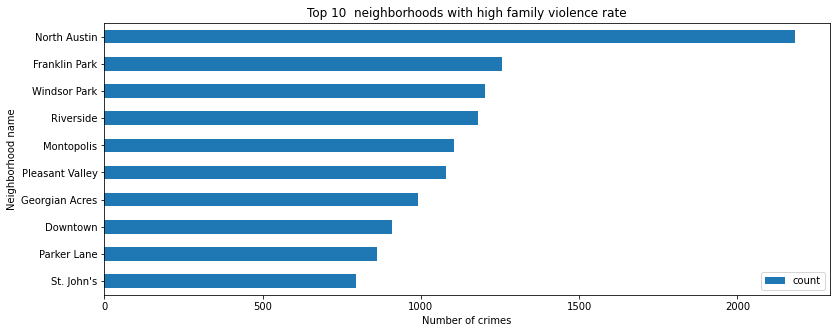

In [64]:
family_violance_top10.plot(kind='barh', figsize=(13, 5))

plt.title('Top 10  neighborhoods with high family violence rate')
plt.xlabel('Number of crimes')
plt.ylabel('Neighborhood name')

plt.show()

In [65]:
family_violance = family_violance.reset_index()

In [66]:
fv = folium.Map(location=[30.2711286, -97.7436995], zoom_start=11)

fv.choropleth(
    geo_data=r'austin.geojson',
    name='Family violences',
    data=family_violance,
    columns=['index', 'count'],
    fill_color='YlOrRd',
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Number of crimes',
    key_on= 'feature.properties.name',
)  

fv

 <a id='item233'></a>

## 2.3.3 Part 1 offenses by UCR Offense Definitions
In the traditional Summary Reporting System (SRS), there are eight crimes, or Part I offenses, (murder and nonnegligent homicide, rape (legacy & revised), robbery, aggravated assault, burglary, motor vehicle theft, larceny-theft, and arson) to be reported to the UCR Program. These offenses were chosen because they are serious crimes, they occur with regularity in all areas of the country, and they are likely to be reported to police.

In [67]:
crimes = crime['UCR Category'].unique()
crimes

array([nan, '23F', '23H', '23C', '220', '23E', '240', '13A', '23G', '120',
       '23D', '23A', '09A', '23B'], dtype=object)

#### Replace value to 1 for severe crimes and 0 if it is not Part I offense.

In [68]:
crime['UCR Category'].replace(crimes[1:], 1, inplace = True)

In [69]:
crime['UCR Category'].replace(np.NaN, 0, inplace = True)

In [70]:
crime['UCR Category'].unique()

array([0., 1.])

In [71]:
crime['Category Description'].value_counts().to_frame()

Category Description
Theft                             100035
Burglary                           16820
Auto Theft                          9216
Aggravated Assault                  8161
Robbery                             4240
Murder                               128

In [72]:
offenses = crime['Category Description'].value_counts().to_frame(name='percent')
offenses['percent'] = offenses['percent']/crime.shape[0]*100
offenses

percent
Theft               24.597541
Burglary             4.135859
Auto Theft           2.266116
Aggravated Assault   2.006703
Robbery              1.042571
Murder               0.031474

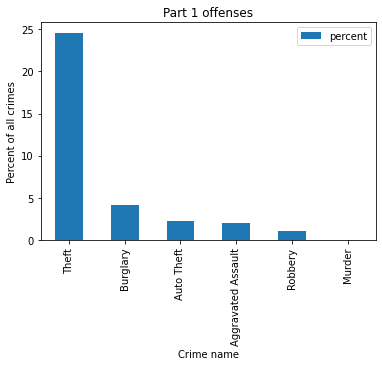

In [73]:
offenses.plot(kind='bar')

plt.title('Part 1 offenses')
plt.ylabel('Percent of all crimes')
plt.xlabel('Crime name')

plt.show()

In [74]:
partI = crime.loc[crime['UCR Category'] == 1]

In [75]:
partI.head()

Highest Offense Description  Highest Offense Code Family Violence  \
1              THEFT FROM AUTO                   603               N   
6          BURGLARY OF VEHICLE                   601               N   
8          BURGLARY OF VEHICLE                   601               N   
9             THEFT OF BICYCLE                   609               N   
11        THEFT BY SHOPLIFTING                   607               N   

   Occurred Date  Occurred Time Report Date  Report Time  \
1     2016-08-12          730.0  2016-08-12       1503.0   
6     2020-03-06          330.0  2020-03-08       1022.0   
8     2020-03-18            1.0  2020-03-20       1957.0   
9     2019-10-10         1000.0  2019-11-10       1011.0   
11    2015-09-24         1229.0  2015-09-24       1229.0   

                  Location Type  UCR Category Category Description   Latitude  \
1         PARKING LOTS / GARAGE           1.0                Theft  30.321278   
6               OTHER / UNKNOWN           1.0                Theft  30.232921   
8              RESIDENCE / HOME           1.0                Theft  30.241599   
9         PARKING LOTS / GARAGE           1.0                Theft  30.255712   
11  DEPARTMENT / DISCOUNT STORE           1.0                Theft  30.218765   

    Longitude                     Location         Neigbourhood  
1  -97.718254    (30.32127758, -97.718254)  North Loop/Ridgetop  
6  -97.737399  (30.23292142, -97.73739875)            Riverside  
8  -97.825796  (30.24159941, -97.82579572)             Oak Hill  
9  -97.762543  (30.25571164, -97.76254277)               Zilker  
11 -97.756150  (30.21876465, -97.75615042)        East Congress

In [76]:
partI.reset_index(drop=True)

Highest Offense Description  Highest Offense Code Family Violence  \
0                  THEFT FROM AUTO                   603               N   
1              BURGLARY OF VEHICLE                   601               N   
2              BURGLARY OF VEHICLE                   601               N   
3                 THEFT OF BICYCLE                   609               N   
4             THEFT BY SHOPLIFTING                   607               N   
...                            ...                   ...             ...   
138595         BURGLARY OF VEHICLE                   601               N   
138596        THEFT BY SHOPLIFTING                   607               N   
138597                       THEFT                   600               N   
138598         BURGLARY OF VEHICLE                   601               N   
138599                       THEFT                   600               N   

       Occurred Date  Occurred Time Report Date  Report Time  \
0         2016-08-12          730.0  2016-08-12       1503.0   
1         2020-03-06          330.0  2020-03-08       1022.0   
2         2020-03-18            1.0  2020-03-20       1957.0   
3         2019-10-10         1000.0  2019-11-10       1011.0   
4         2015-09-24         1229.0  2015-09-24       1229.0   
...              ...            ...         ...          ...   
138595    2017-09-25         1059.0  2017-09-25       1059.0   
138596    2016-02-13         2204.0  2016-02-13       2210.0   
138597    2015-12-20         1200.0  2015-12-20       1408.0   
138598    2016-05-04         2100.0  2016-05-05        930.0   
138599    2018-11-25         1600.0  2018-11-25       1730.0   

                      Location Type  UCR Category Category Description  \
0             PARKING LOTS / GARAGE           1.0                Theft   
1                   OTHER / UNKNOWN           1.0                Theft   
2                  RESIDENCE / HOME           1.0                Theft   
3             PARKING LOTS / GARAGE           1.0                Theft   
4       DEPARTMENT / DISCOUNT STORE           1.0                Theft   
...                             ...           ...                  ...   
138595        PARKING LOTS / GARAGE           1.0                Theft   
138596       GAS / SERVICE STATIONS           1.0                Theft   
138597        PARKING LOTS / GARAGE           1.0                Theft   
138598        PARKING LOTS / GARAGE           1.0                Theft   
138599        GROCERY / SUPERMARKET           1.0                Theft   

         Latitude  Longitude                     Location         Neigbourhood  
0       30.321278 -97.718254    (30.32127758, -97.718254)  North Loop/Ridgetop  
1       30.232921 -97.737399  (30.23292142, -97.73739875)            Riverside  
2       30.241599 -97.825796  (30.24159941, -97.82579572)             Oak Hill  
3       30.255712 -97.762543  (30.25571164, -97.76254277)               Zilker  
4       30.218765 -97.756150  (30.21876465, -97.75615042)        East Congress  
...           ...        ...                          ...                  ...  
138595  30.238207 -97.726243  (30.23820652, -97.72624311)            Riverside  
138596  30.333534 -97.686681  (30.33353443, -97.68668087)       Heritage Hills  
138597  30.334547 -97.700319  (30.33454682, -97.70031898)           St. John's  
138598  30.262866 -97.758610  (30.26286603, -97.75861046)               Zilker  
138599  30.334253 -97.741086  (30.33425261, -97.74108649)            Allandale  

[138600 rows x 14 columns]

In [77]:
locations = partI['Location Type'].value_counts().to_frame(name="count")

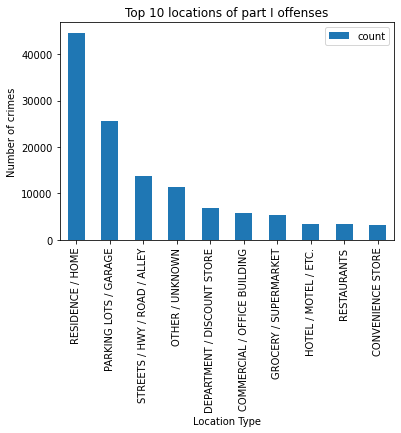

In [78]:
locations.head(10).plot(kind = 'bar')

plt.xlabel('Location Type')
plt.ylabel('Number of crimes')
plt.title('Top 10 locations of part I offenses')

plt.show()

## Part I offenses map

In [79]:
offenses = partI['Neigbourhood'].value_counts().to_frame(name="count")

In [80]:
offenses.head()

count
Downtown      12303
North Austin   7513
Riverside      6082
Windsor Park   5203
North Burnet   4733

In [81]:
offenses = offenses.reset_index()

In [82]:
pi = folium.Map(location=[30.2711286, -97.7436995], zoom_start=11)

pi.choropleth(
    geo_data=r'austin.geojson',
    name='part I offenses',
    data=offenses,
    columns=['index', 'count'],
    fill_color='YlOrRd',
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Number of crimes',
    key_on= 'feature.properties.name',
)  

pi

## Bin part I crimes
#### Creating bins of severe crimes by cutting data into six categories:
#### Safe, Mid. Safe, Medium crimes, Mid. Dangerous, Dangerous, Extremely Dangerous"
#### 
#### This data will be used for the last neighborhood clustering.

In [83]:
crime_names = ["Safe", "Mid. Safe", "Medium crimes" , "Mid. Dangerous", "Dangerous" ,"Extremely Dangerous"]
bins = np.linspace(min(offenses["count"]), max(offenses["count"]), 7)
offenses["partI"] = pd.cut(offenses["count"],
                            bins, labels = crime_names,
                            include_lowest = True)

In [84]:
offenses.head(10)

index  count                partI
0         Downtown  12303  Extremely Dangerous
1     North Austin   7513       Mid. Dangerous
2        Riverside   6082        Medium crimes
3     Windsor Park   5203        Medium crimes
4     North Burnet   4733        Medium crimes
5         Oak Hill   4354        Medium crimes
6      West Campus   4059            Mid. Safe
7  Pleasant Valley   4046            Mid. Safe
8   Heritage Hills   3914            Mid. Safe
9       St. John's   3686            Mid. Safe

In [85]:
offenses.tail(10)

index  count partI
60  Pemberton Heights and Bryker Woods    466  Safe
61                            Chestnut    420  Safe
62                    Johnston Terrace    412  Safe
63                    Wilshire/Delwood    174  Safe
64                         Old Enfield    148  Safe
65                     Oakmont Heights    145  Safe
66                           Blackland    144  Safe
67                 University of Texas    121  Safe
68        Rogers-Washington-Holy Cross    108  Safe
69                            Ridgelea     68  Safe

In [86]:
offenses.rename(columns = {'index':'name'}, inplace = True)

In [87]:
offenses.drop('count', 1, inplace = True)

<a id='item3'></a>


# 3. Rent data

#### Average rent per house scratched from here, and some popular sites before and wrote to a CSV file. Consist average price for rent per house neighborhoods. It will help to understand how the cost distributed by areas.

In [88]:
rent = pd.read_csv('rent.csv')
rent.head()

name bedrooms  price
0  Downtown        1   1652
1  Downtown        3   2450
2  Downtown        1   1696
3  Downtown        1   2175
4  Downtown       st   1539

<a id='item31'></a>

### 3.1 Analysis

In [89]:
bedrooms_counts = rent["bedrooms"].value_counts()
bedrooms_counts

2     697
1     528
3     460
st    132
4     104
5      19
6       8
7       3
9       1
13      1
Name: bedrooms, dtype: int64

In [90]:
bedrooms_counts = rent["bedrooms"].value_counts().to_frame()
bedrooms_counts.rename(columns={'bedrooms': 'value_counts'}, inplace=True)
bedrooms_counts

value_counts
2            697
1            528
3            460
st           132
4            104
5             19
6              8
7              3
9              1
13             1

### Price distribution for all properties up to 6000 dollars

In [91]:
rent_6000 = rent.loc[rent['price'] < 6000]

Text(0.5, 1.0, 'Price distribution by numbers of rooms')

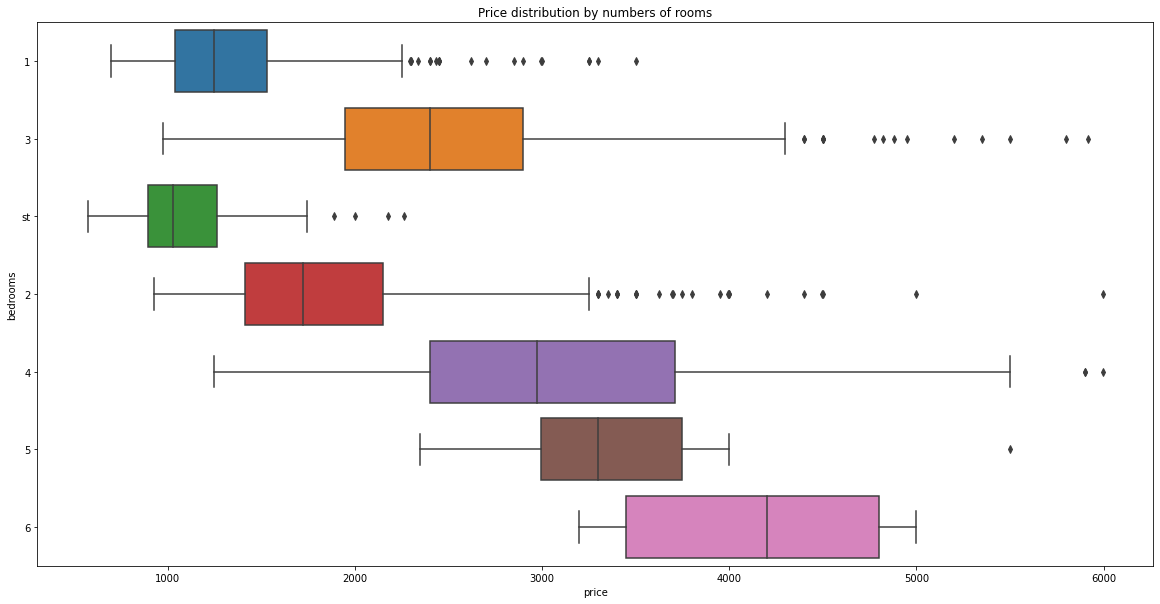

In [92]:
plt.figure(figsize=(20,10))
sns.boxplot(
    data=rent_6000,
    x='price',
    y='bedrooms').set_title('Price distribution by numbers of rooms')

Text(0.5, 1.0, 'Price distribution by neighborhoods')

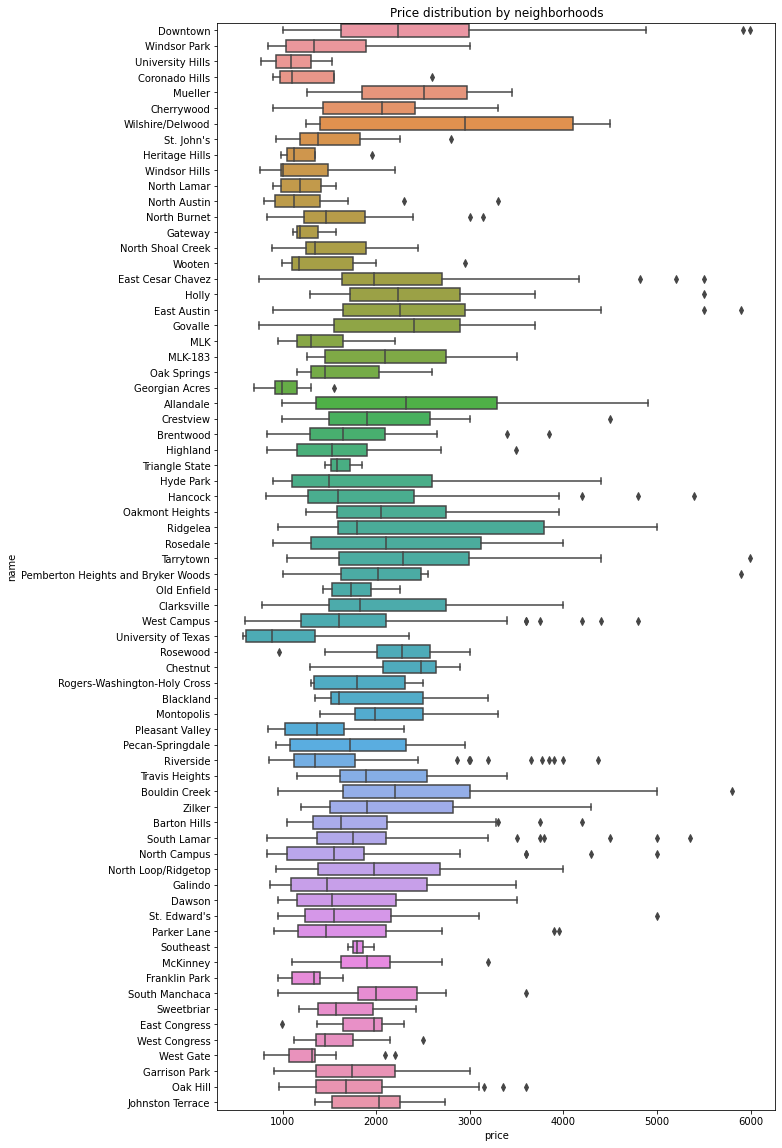

In [93]:
plt.figure(figsize=(10,20))
sns.boxplot(
    data=rent_6000,
    x='price',
    y='name').set_title('Price distribution by neighborhoods')

### Find the median for every neighborhood

In [94]:
median_price_ngh = rent[['name','price']]
median_price_ngh = median_price_ngh.groupby(['name'],as_index=False).median()
median_price_ngh.sort_values(by=['price'], inplace = True)
median_price_ngh.head()

name   price
61  University of Texas   885.0
19       Georgian Acres   999.0
66        Windsor Hills  1000.0
60     University Hills  1088.0
8        Coronado Hills  1099.5

<a id='item32'></a>

## 3.2 Binning median rent data
##### Creating bins of median rate by dividing data into three categories:
##### Low price, Medium price, and High price
##### This data will be used for the last neighborhood clustering.

In [95]:
bins = np.linspace(min(median_price_ngh["price"]), max(median_price_ngh["price"]), 4)
bins

array([ 885.        , 1573.33333333, 2261.66666667, 2950.        ])

In [96]:
group_names = ["Low price", "Medium price","High price"]

In [97]:
median_price_ngh["price-binned"] = pd.cut(median_price_ngh["price"], bins, labels = group_names, include_lowest = True)

In [98]:
median_price_ngh["price-binned"].value_counts()

Medium price    32
Low price       29
High price       9
Name: price-binned, dtype: int64

### High-price neighborhoods:

In [99]:
median_price_ngh.loc[median_price_ngh["price-binned"] == 'High price'].sort_values(by = 'price',ascending=False)

name   price price-binned
65  Wilshire/Delwood  2950.0   High price
31           Mueller  2514.0   High price
6           Chestnut  2500.0   High price
20           Govalle  2425.0   High price
12       East Austin  2400.0   High price
57         Tarrytown  2400.0   High price
0          Allandale  2322.5   High price
11          Downtown  2295.0   High price
50          Rosewood  2275.0   High price

Text(0.5, 1.0, 'Price bins')

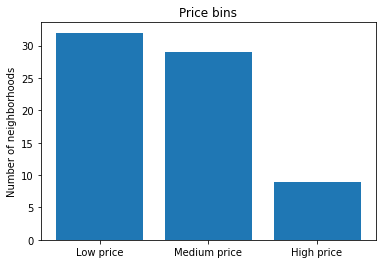

In [100]:
%matplotlib inline

plt.bar(group_names, median_price_ngh["price-binned"].value_counts())

# set x/y labels and plot title
plt.ylabel("Number of neighborhoods")
plt.title("Price bins")

Text(0.5, 1.0, 'Price bins')

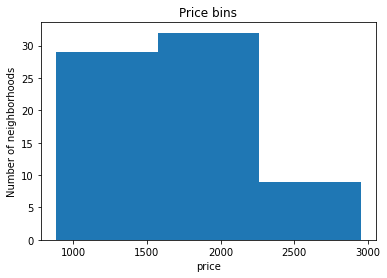

In [101]:
%matplotlib inline

a = (0,1,2)

# draw historgram of attribute "price" with bins = 3
plt.hist(median_price_ngh["price"], bins = 3)

# set x/y labels and plot title
plt.xlabel("price")
plt.ylabel("Number of neighborhoods")
plt.title("Price bins")

## Choproleth rent map.

In [102]:
rent_poligon = pd.merge_ordered(neigh, median_price_ngh, fill_method='ffill', left_by='name')

In [103]:
rent_poligon.head()

geometry           name  \
0  MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...      Blackland   
1  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...  Bouldin Creek   
2  MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...      Brentwood   
3  MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...     Cherrywood   
4  MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...       Chestnut   

    latitude  longtitude   price  price-binned  
0  30.281794  -97.721684  1600.0  Medium price  
1  30.251705  -97.755626  2200.0  Medium price  
2  30.330625  -97.732451  1650.0  Medium price  
3  30.290292  -97.715019  2061.0  Medium price  
4  30.277860  -97.715049  2500.0    High price

In [104]:
r = folium.Map(location=[30.2711286, -97.7436995], zoom_start=12)

r.choropleth(
    geo_data=r'austin.geojson',
    name='Rent',
    data=rent_poligon,
    columns=['name','price'],
    fill_color='YlOrRd',
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Price for rent per house',
    key_on= 'feature.properties.name',
)  


latitudes = list(rent_poligon['latitude'])
longitudes = list(rent_poligon['longtitude'])
names = list(rent_poligon['name'])
rent = list(rent_poligon['price'])

# add markers 
for lat, lon, name, rent in zip(latitudes, longitudes, names, rent):
    folium.Marker([lat, lon], popup=folium.Popup(f'{html.escape(name)}, {rent}')).add_to(r)

r

In [105]:
median_price_ngh = median_price_ngh[['name', 'price-binned']]

In [106]:
median_price_ngh.head()

name price-binned
61  University of Texas    Low price
19       Georgian Acres    Low price
66        Windsor Hills    Low price
60     University Hills    Low price
8        Coronado Hills    Low price

<a id='item4'></a>

# 4. Venues
## Exploring venues around every neighborhood using Foursquare

In [107]:
config = configparser.ConfigParser()
config.read('example.ini')
config.sections()

['Foursquare']

In [108]:
# Values for searching through Foursquare
CLIENT_ID = config['Foursquare']['CLIENT_ID']
CLIENT_SECRET = config['Foursquare']['CLIENT_SECRET']
VERSION = config['Foursquare']['VERSION']

LIMIT = 100

In [109]:
neigh.head()

geometry           name  \
0  MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...      Blackland   
1  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...  Bouldin Creek   
2  MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...      Brentwood   
3  MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...     Cherrywood   
4  MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...       Chestnut   

    latitude  longtitude  
0  30.281794  -97.721684  
1  30.251705  -97.755626  
2  30.330625  -97.732451  
3  30.290292  -97.715019  
4  30.277860  -97.715049

<a id='item41'></a>

### 4.1 Extract categories

### Create a function that extracts the category of the venue

In [110]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Function for creating Data Frame with all venues within radius 1000 meters from a neighborhood center.

In [111]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    s = requests.Session()
    for name, lat, lng in zip(names, latitudes, longitudes):      
        # create the API request URL
        payload = {
            'client_id': CLIENT_ID,
            'client_secret': CLIENT_SECRET,
            'v': VERSION,
            'll': f'{lat},{lng}',
            'radius': radius,
            'limit' : LIMIT
        }
        
            
        # make the GET request
        
        #to prevent code to crush
        r = None
        while r is None or r.status_code != 200:
            r = s.get('https://api.foursquare.com/v2/venues/explore', params=payload)
        
        
        results = r.json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [112]:
austin_venues = getNearbyVenues(names=neigh['name'],
                                   latitudes=neigh['latitude'],
                                   longitudes=neigh['longtitude']
                                  )

In [113]:
print(austin_venues.shape)
austin_venues.head()

(3521, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Blackland              30.281794              -97.721684   
1    Blackland              30.281794              -97.721684   
2    Blackland              30.281794              -97.721684   
3    Blackland              30.281794              -97.721684   
4    Blackland              30.281794              -97.721684   

                     Venue  Venue Latitude  Venue Longitude  \
0                The Wheel       30.280237       -97.720928   
1         Sour Duck Market       30.279895       -97.721531   
2                Salty Sow       30.283913       -97.721436   
3                JuiceLand       30.280004       -97.721086   
4  El Chile Cafe y Cantina       30.283654       -97.722503   

        Venue Category  
0                  Bar  
1           Restaurant  
2  American Restaurant  
3            Juice Bar  
4   Mexican Restaurant

In [114]:
austin_venues['Neighborhood'].value_counts()

Wilshire/Delwood                      100
Zilker                                100
Gateway                               100
Downtown                              100
Bouldin Creek                         100
East Austin                           100
University of Texas                   100
Riverside                             100
East Cesar Chavez                     100
West Campus                           100
Triangle State                         92
Clarksville                            90
Holly                                  88
North Campus                           87
North Shoal Creek                      78
Wooten                                 78
Highland                               76
Govalle                                75
West Gate                              74
Brentwood                              72
Chestnut                               72
Travis Heights                         70
Hancock                                70
North Loop/Ridgetop               

In [115]:
print(f'There are {len(austin_venues["Venue Category"].unique())} uniques categories.')

There are 323 uniques categories.


## Creating dataframe with venue columns

In [116]:
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")
austin_onehot.head()

ATM  Adult Boutique  Advertising Agency  African Restaurant  \
0    0               0                   0                   0   
1    0               0                   0                   0   
2    0               0                   0                   0   
3    0               0                   0                   0   
4    0               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    1             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0            0           0                    0                 0           0   
1            0           0                    0                 0           0   
2            0           0                    0                 0           0   
3            0           0                    0                 0           0   
4            0           0                    0                 0           0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    1               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Basketball Court  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0          0                0         0            0   
1                 0          0                0         0            0   
2                 0          0                0         0            0   
3                 0          0                0         0            0   
4                 0          0                0         0            0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bike Shop  Bookstore  \
0           0              0                         0          0          0   
1           0              0                         0          0          0   
2           0              0                         0          0          0   
3           0              0                         0          0          0   
4           0              0                         0          0          0   

   Boutique  Bowling Alley  Boxing Gym  Breakfast Spot  Brewery  Bridal Shop  \
0         0              0           0               0        0            0   
1         0              0           0               0        0            0   
2         0              0           0               0        0            0   
3         0              0           0               0        0            0   
4         0              0           0               0        0            0   

   Bridge  Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  \
0       0                0             0              0         0   
1       0                0             0              0         0   
2       0                0             0              0         0   
3       0                0             0              0         0   
4       0                0      

### add neighborhood column to the first column dataframe

In [117]:
austin_onehot['Neighborhood'] = austin_venues['Neighborhood']
austin_onehot.head()

ATM  Adult Boutique  Advertising Agency  African Restaurant  \
0    0               0                   0                   0   
1    0               0                   0                   0   
2    0               0                   0                   0   
3    0               0                   0                   0   
4    0               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    1             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0            0           0                    0                 0           0   
1            0           0                    0                 0           0   
2            0           0                    0                 0           0   
3            0           0                    0                 0           0   
4            0           0                    0                 0           0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    1               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Basketball Court  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0          0                0         0            0   
1                 0          0                0         0            0   
2                 0          0                0         0            0   
3                 0          0                0         0            0   
4                 0          0                0         0            0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bike Shop  Bookstore  \
0           0              0                         0          0          0   
1           0              0                         0          0          0   
2           0              0                         0          0          0   
3           0              0                         0          0          0   
4           0              0                         0          0          0   

   Boutique  Bowling Alley  Boxing Gym  Breakfast Spot  Brewery  Bridal Shop  \
0         0              0           0               0        0            0   
1         0              0           0               0        0            0   
2         0              0           0               0        0            0   
3         0              0           0               0        0            0   
4         0              0           0               0        0            0   

   Bridge  Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  \
0       0                0             0              0         0   
1       0                0             0              0         0   
2       0                0             0              0         0   
3       0                0             0              0         0   
4       0                0      

In [118]:
cols = list(austin_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
austin_onehot = austin_onehot[['Neighborhood'] + cols]
austin_onehot.head()

Neighborhood  ATM  Adult Boutique  Advertising Agency  African Restaurant  \
0    Blackland    0               0                   0                   0   
1    Blackland    0               0                   0                   0   
2    Blackland    0               0                   0                   0   
3    Blackland    0               0                   0                   0   
4    Blackland    0               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    1             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0            0           0                    0                 0           0   
1            0           0                    0                 0           0   
2            0           0                    0                 0           0   
3            0           0                    0                 0           0   
4            0           0                    0                 0           0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    1               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Basketball Court  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0          0                0         0            0   
1                 0          0                0         0            0   
2                 0          0                0         0            0   
3                 0          0                0         0            0   
4                 0          0                0         0            0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bike Shop  Bookstore  \
0           0              0                         0          0          0   
1           0              0                         0          0          0   
2           0              0                         0          0          0   
3           0              0                         0          0          0   
4           0              0                         0          0          0   

   Boutique  Bowling Alley  Boxing Gym  Breakfast Spot  Brewery  Bridal Shop  \
0         0              0           0               0        0            0   
1         0              0           0               0        0            0   
2         0              0           0               0        0            0   
3         0              0           0               0        0            0   
4         0              0           0               0        0            0   

   Bridge  Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  \
0       0                0             0              0         0   
1       0                0             0              0         0   
2       0                0             0              0         0   
3       0             

In [119]:
austin_onehot.shape

(3521, 324)

In [120]:
austin_grouped = austin_onehot.groupby('Neighborhood').mean().reset_index()

In [121]:
austin_grouped.head()

Neighborhood  ATM  Adult Boutique  Advertising Agency  African Restaurant  \
0      Allandale  0.0             0.0                 0.0                 0.0   
1   Barton Hills  0.0             0.0                 0.0                 0.0   
2      Blackland  0.0             0.0                 0.0                 0.0   
3  Bouldin Creek  0.0             0.0                 0.0                 0.0   
4      Brentwood  0.0             0.0                 0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0             0.000000      0.000000     0.0                     0.0   
1             0.000000      0.000000     0.0                     0.0   
2             0.034483      0.000000     0.0                     0.0   
3             0.010000      0.000000     0.0                     0.0   
4             0.027778      0.013889     0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0     0.000000         0.0                 0.00          0.000000         0.0   
1     0.000000         0.0                 0.00          0.000000         0.0   
2     0.017241         0.0                 0.00          0.000000         0.0   
3     0.010000         0.0                 0.02          0.000000         0.0   
4     0.000000         0.0                 0.00          0.013889         0.0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0            0.000000              0.0          0.0            0.0   
1            0.000000              0.0          0.0            0.0   
2            0.017241              0.0          0.0            0.0   
3            0.000000              0.0          0.0            0.0   
4            0.000000              0.0          0.0            0.0   

   Automotive Shop  BBQ Joint  Bagel Shop    Bakery  Bank       Bar  \
0              0.0   0.000000    0.000000  0.000000   0.0  0.071429   
1              0.0   0.000000    0.000000  0.000000   0.0  0.000000   
2              0.0   0.034483    0.000000  0.000000   0.0  0.068966   
3              0.0   0.010000    0.000000  0.010000   0.0  0.010000   
4              0.0   0.000000    0.013889  0.013889   0.0  0.013889   

   Baseball Field  Basketball Court  Beach Bar  Bed & Breakfast  Beer Bar  \
0        0.035714               0.0        0.0             0.00  0.035714   
1        0.000000               0.0        0.0             0.00  0.000000   
2        0.017241               0.0        0.0             0.00  0.000000   
3        0.000000               0.0        0.0             0.01  0.000000   
4        0.000000               0.0        0.0             0.00  0.000000   

   Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0          0.0         0.0            0.0                       0.0   
1          0.0         0.0            0.0                       0.0   
2          0.0         0.0            0.0                       0.0   
3          0.0         0.0            0.0                       0.0   
4          0.0         0.0            0.0                       0.0   

   Bike Shop  Bookstore  Boutique  Bowling Alley  Boxing Gym  Breakfast Spot  \
0        0.0   0.000000      0.00       0.000000    0.000000        0.000000   
1        0.0   0.000000      0.00       0.000000    0.000000        0.000000   
2        0.0   0.000000      0.00       0.000000    0.000000        0.017241   
3        0.0   0.010000      0.02       0.000000    0.000000        0.010000   
4        0.0   0.041667      0.00       0.013889    0.013889        0.000000   

   Brewery  Bridal Shop  Bridge  Bubble Tea Shop  Burger Joint  Burrito Place  \
0      0.0          0.0     0.0              0.0      0.000000            0.0   
1      0.0          0.0     0.0              0.0      0.000000            0.0   
2      0.0          0.0     0.0              0.0      0.000000            0.0   
3      0.0          0.0     0.0              0.0      

In [122]:
austin_grouped.shape

(70, 324)

<a id='item42'></a>
### 4.2 Most common venues

## Creating a data frame with the most common venues for all neighborhoods

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [124]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(f'{ind+1}{indicators[ind]} Most Common Venue')
    except:
        columns.append(f'{ind+1}th Most Common Venue')

ngh_venues_sorted = pd.DataFrame(columns=columns)
ngh_venues_sorted['Neighborhood'] = austin_grouped['Neighborhood']

for ind in np.arange(austin_grouped.shape[0]):
    ngh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

ngh_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0      Allandale            Food Truck                   Bar   
1   Barton Hills                  Pool                 Trail   
2      Blackland          Cocktail Bar                   Bar   
3  Bouldin Creek           Coffee Shop            Food Truck   
4      Brentwood          Burger Joint    Mexican Restaurant   

                      3rd Most Common Venue 4th Most Common Venue  \
0                                      Pool                   Spa   
1  Residential Building (Apartment / Condo)            Food Truck   
2                               Coffee Shop            Restaurant   
3                            Ice Cream Shop  Gym / Fitness Center   
4                                 Bookstore           Coffee Shop   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                 Beer Bar         Garden Center                Lounge   
1          Nature Preserve            Taco Place  Other Great Outdoors   
2               Food Truck               Theater    Mexican Restaurant   
3  New American Restaurant       Thai Restaurant    Salon / Barbershop   
4                Pet Store          Liquor Store             Gift Shop   

  8th Most Common Venue 9th Most Common Venue  10th Most Common Venue  
0           Supermarket      Storage Facility             Pizza Place  
1                  Park                   Gym          Scenic Lookout  
2                  Café             BBQ Joint          Sandwich Place  
3    Mexican Restaurant        Sandwich Place                   Hotel  
4       Thai Restaurant           Pizza Place  Thrift / Vintage Store

<a id='item43'></a>
## 4.3 Clustering venues dataframe

In [125]:
austin_grouped_clustering = austin_grouped.drop('Neighborhood', 1)

In [185]:
ngh_venues_sorted.drop('Cluster Labels', 1, inplace = True)

In [186]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 1, 1], dtype=int32)

In [187]:
# add clustering labels
ngh_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

austin_merged = neigh

# merge to add latitude/longitude for each neighborhood
austin_merged = austin_merged.join(ngh_venues_sorted.set_index('Neighborhood'), on='name')

In [188]:
austin_merged['Cluster Labels'].value_counts()

4    45
1    18
2     4
0     2
3     1
Name: Cluster Labels, dtype: int64

In [189]:
austin_merged.head()

geometry           name  \
0  MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...      Blackland   
1  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...  Bouldin Creek   
2  MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...      Brentwood   
3  MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...     Cherrywood   
4  MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...       Chestnut   

    latitude  longtitude  Cluster Labels 1st Most Common Venue  \
0  30.281794  -97.721684               4          Cocktail Bar   
1  30.251705  -97.755626               4           Coffee Shop   
2  30.330625  -97.732451               4          Burger Joint   
3  30.290292  -97.715019               4            Taco Place   
4  30.277860  -97.715049               4                   Bar   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   Bar           Coffee Shop            Restaurant   
1            Food Truck        Ice Cream Shop  Gym / Fitness Center   
2    Mexican Restaurant             Bookstore           Coffee Shop   
3               Theater            Food Truck        Massage Studio   
4     Convenience Store               Theater           Coffee Shop   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0               Food Truck               Theater    Mexican Restaurant   
1  New American Restaurant       Thai Restaurant    Salon / Barbershop   
2                Pet Store          Liquor Store             Gift Shop   
3              Coffee Shop                   Bar             BBQ Joint   
4             Cocktail Bar                  Park            Taco Place   

  8th Most Common Venue 9th Most Common Venue  10th Most Common Venue  
0                  Café             BBQ Joint          Sandwich Place  
1    Mexican Restaurant        Sandwich Place                   Hotel  
2       Thai Restaurant           Pizza Place  Thrift / Vintage Store  
3    Mexican Restaurant          Intersection          Sandwich Place  
4        Sandwich Place            Lighthouse              Food Truck

### Number of neighborhoods in every cluster

## Visualize clusters

In [190]:
map_clusters = folium.Map(location=[30.2711286, -97.7436995], zoom_start=11)

map_clusters.choropleth(
    geo_data='austin.geojson',
    name='Neighbourhoods',
    fill_color='pink',
    fill_opacity=0.3, 
    line_opacity=0.2,
)  


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, ngh, cluster in zip(austin_merged['latitude'],
                                  austin_merged['longtitude'],
                                  austin_merged['name'],
                                  austin_merged['Cluster Labels']):
    label = folium.Popup(str(ngh) + ', Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item44'></a>
## 4.4 Wordcloude visualization

## Function for creating worlcloud

In [205]:
def cluster_word_cloud(cluster):
    cluster = cluster.drop(['name'], 1)
    # create string with all venues
    cluster_words = []
    for counter, column in enumerate(cluster):
        for values in cluster[column]:
            cluster_words += values.split()*(10-counter)
    cluster_words = ', '.join(cluster_words)

    # instantiate a word cloud object
    cluster_cloud = WordCloud(
        background_color='white',
        max_words=90)

    # generate the word cloud
    cluster_cloud.generate(cluster_words)
    
    # creating plot
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(18)

    # display the cloud
    plt.imshow(cluster_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [206]:
Cluster1 = austin_merged.loc[austin_merged['Cluster Labels'] == 0, austin_merged.columns[[1] + list(range(5, austin_merged.shape[1]))]]
Cluster1.head()

name 1st Most Common Venue 2nd Most Common Venue  \
21               MLK                  Park           Yoga Studio   
33  Pecan-Springdale                  Park                 Motel   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
21     Outdoor Sculpture           Golf Course     Convenience Store   
33         Auto Workshop        Discount Store          Fire Station   

         6th Most Common Venue 7th Most Common Venue  \
21  Construction & Landscaping            Hobby Shop   
33          Falafel Restaurant                  Farm   

        8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
21  Cajun / Creole Restaurant             BBQ Joint            Gas Station  
33             Farmers Market  Fast Food Restaurant                  Field

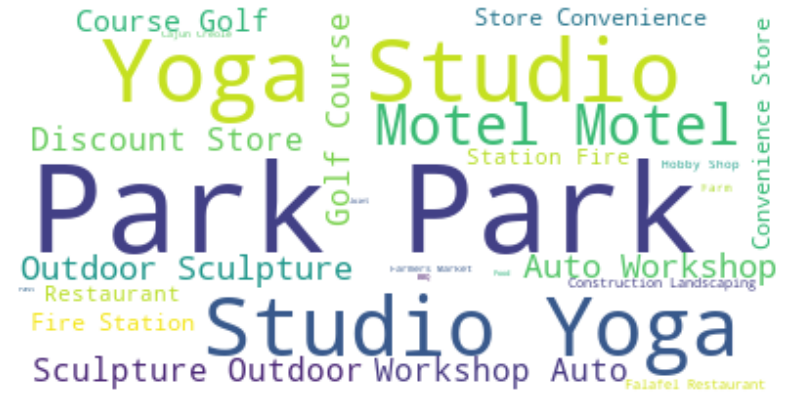

In [207]:
cluster_word_cloud(Cluster1)

## Cluster #1 Most common venues appear to be park zone and sport venues. These neighborhoods would be suitable for someone who loves outdoor activities and love sport.

In [208]:
Cluster2 = austin_merged.loc[austin_merged['Cluster Labels'] == 1,
                             austin_merged.columns[[1] + list(range(5, austin_merged.shape[1]))]]
Cluster2.head()

name  1st Most Common Venue   2nd Most Common Venue  \
6          Crestview     Mexican Restaurant  Furniture / Home Store   
11     Franklin Park            Video Store              Food Truck   
14           Govalle            Art Gallery                    Farm   
20  Johnston Terrace            Art Gallery      Mexican Restaurant   
28       North Lamar  Vietnamese Restaurant          Discount Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6                    Gym                Bakery           Yoga Studio   
11     Convenience Store          Intersection                  Park   
14    Mexican Restaurant               Brewery            Food Truck   
20           Gas Station          Burger Joint                 Trail   
28   Rental Car Location            Food Truck    Mexican Restaurant   

            6th Most Common Venue   7th Most Common Venue  \
6                     Coffee Shop               Pawn Shop   
11             Mexican Restaurant         Supplement Shop   
14                    Coffee Shop  Thrift / Vintage Store   
20  Paper / Office Supplies Store  Thrift / Vintage Store   
28                           Bank  Furniture / Home Store   

   8th Most Common Venue       9th Most Common Venue 10th Most Common Venue  
6            Pizza Place                  Comic Shop         Clothing Store  
11        Rental Service                         Gym      Martial Arts Dojo  
14           Gas Station               Garden Center      Food & Drink Shop  
20     Convenience Store  Construction & Landscaping                   Park  
28     Convenience Store          Chinese Restaurant            Supermarket

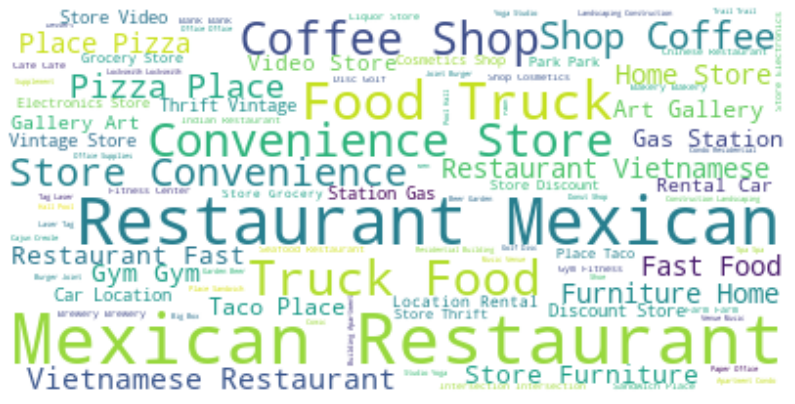

In [209]:
cluster_word_cloud(Cluster2)

### Cluster #2 Most popular venues appear to be multi-social venues. In these neighborhoods, you could find plenty of places you like. These neighborhoods would be suitable for someone who loves to go to different sites, meet with friends.

In [210]:
Cluster3 = austin_merged.loc[austin_merged['Cluster Labels'] == 2, austin_merged.columns[[1] + list(range(5, austin_merged.shape[1]))]]
Cluster3.head()

name 1st Most Common Venue 2nd Most Common Venue  \
10   East Congress                 Hotel            Food Truck   
13  Georgian Acres                 Hotel            Food Truck   
24      Montopolis            Food Truck    Mexican Restaurant   
56      St. John's                 Hotel    Mexican Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
10           Coffee Shop   Rental Car Location               Brewery   
13                   Gym          Intersection  Fast Food Restaurant   
24                 Hotel     Convenience Store           Gas Station   
56            Food Truck  Fast Food Restaurant        Breakfast Spot   

   6th Most Common Venue      7th Most Common Venue 8th Most Common Venue  \
10    Mexican Restaurant                       Park            Restaurant   
13           Music Venue             Ice Cream Shop                 Motel   
24            Taco Place  Latin American Restaurant            Smoke Shop   
56    Seafood Restaurant              Smoothie Shop     Korean Restaurant   

   9th Most Common Venue 10th Most Common Venue  
10                   Gym   Gym / Fitness Center  
13       Automotive Shop       Storage Facility  
24                  Park             Donut Shop  
56           Beer Garden            Gas Station

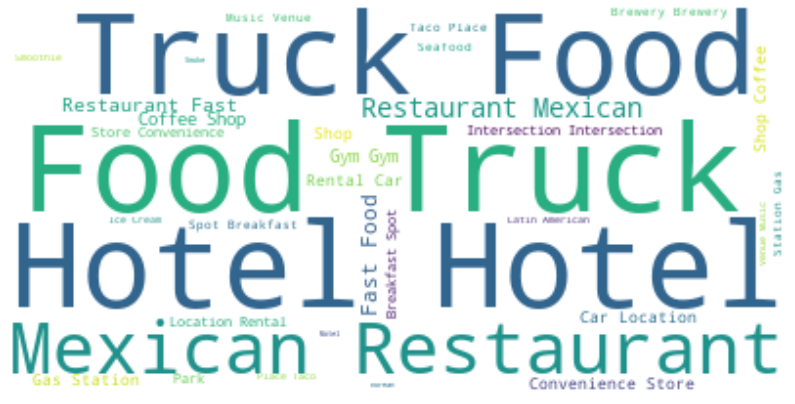

In [211]:
cluster_word_cloud(Cluster3)

### Cluster #3 Most popular venues here are Food Trucks and Hotels. Food trucks are the hallmark of the city. These neighborhoods would be suitable for someone who loves good food or came to Austin for a short period.

In [212]:
Cluster4 = austin_merged.loc[austin_merged['Cluster Labels'] == 3, austin_merged.columns[[1] + list(range(5, austin_merged.shape[1]))]]
Cluster4.head()

name 1st Most Common Venue       2nd Most Common Venue  \
23  McKinney   Sporting Goods Shop  Construction & Landscaping   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
23        Massage Studio           Yoga Studio   Filipino Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
23               Factory    Falafel Restaurant                  Farm   

   9th Most Common Venue 10th Most Common Venue  
23        Farmers Market   Fast Food Restaurant

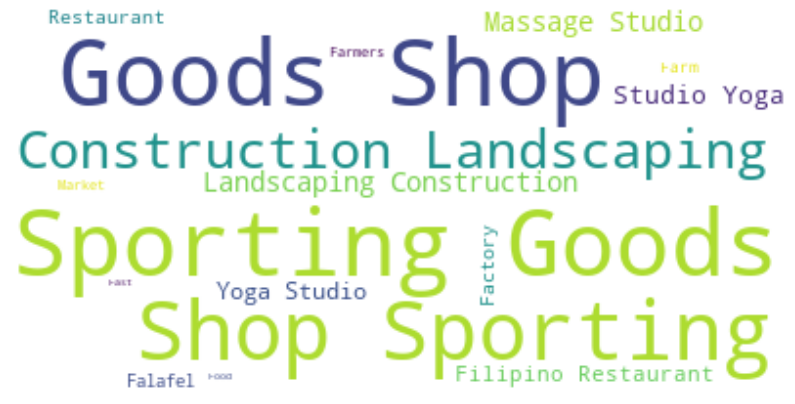

In [213]:
cluster_word_cloud(Cluster4)

### Cluster #4 consists of 1 neighborhood. Sporting goods shop the main venue here. Right area if you don't like many people gathering around

In [214]:
Cluster5 = austin_merged.loc[austin_merged['Cluster Labels'] == 4, austin_merged.columns[[1] + list(range(5, austin_merged.shape[1]))]]
Cluster5.head()

name 1st Most Common Venue 2nd Most Common Venue  \
0      Blackland          Cocktail Bar                   Bar   
1  Bouldin Creek           Coffee Shop            Food Truck   
2      Brentwood          Burger Joint    Mexican Restaurant   
3     Cherrywood            Taco Place               Theater   
4       Chestnut                   Bar     Convenience Store   

  3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
0           Coffee Shop            Restaurant               Food Truck   
1        Ice Cream Shop  Gym / Fitness Center  New American Restaurant   
2             Bookstore           Coffee Shop                Pet Store   
3            Food Truck        Massage Studio              Coffee Shop   
4               Theater           Coffee Shop             Cocktail Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Theater    Mexican Restaurant                  Café   
1       Thai Restaurant    Salon / Barbershop    Mexican Restaurant   
2          Liquor Store             Gift Shop       Thai Restaurant   
3                   Bar             BBQ Joint    Mexican Restaurant   
4                  Park            Taco Place        Sandwich Place   

  9th Most Common Venue  10th Most Common Venue  
0             BBQ Joint          Sandwich Place  
1        Sandwich Place                   Hotel  
2           Pizza Place  Thrift / Vintage Store  
3          Intersection          Sandwich Place  
4            Lighthouse              Food Truck

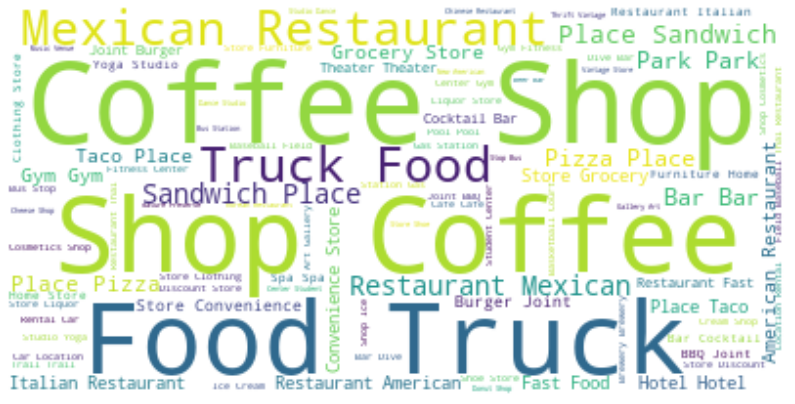

In [215]:
cluster_word_cloud(Cluster5)

##### Prepare the data frame for the next clustering by dropping the count column

In [203]:
venue_clasters = austin_merged[['name','Cluster Labels']]

In [204]:
venue_clasters.head()

name  Cluster Labels
0      Blackland               4
1  Bouldin Creek               4
2      Brentwood               4
3     Cherrywood               4
4       Chestnut               4

<a id='item45'></a>
## 4.5 Name clusters

In [216]:
venue_clasters_name = ['Park zone', 'Multi-social venues', 'Food trucks and hotels', 'Sporting goods', 'Coffee and food venues']

In [217]:
venue_clasters = venue_clasters.replace([0, 1, 2, 3, 4], venue_clasters_name)

In [273]:
venue_clasters.rename(columns={"Cluster Labels": "Venue Cluster"}, inplace = True)

In [274]:
venue_clasters.head()

name           Venue Cluster
0      Blackland  Coffee and food venues
1  Bouldin Creek  Coffee and food venues
2      Brentwood  Coffee and food venues
3     Cherrywood  Coffee and food venues
4       Chestnut  Coffee and food venues

<a id='item5'></a>
# 5. Clustering neighborhoods

#### For the last clustering, we will use 3 data frames: median_price_ngh - df with a categorical median price for every neighborhood; offenses - df with categorical data about the part I offenses it is more severe than usual crime data; venue_clasters - categorical clusters name of venue cluster. 

## Create data frame for clustering

In [ ]:
df = pd.merge_ordered(pd.merge_ordered(median_price_ngh, offenses, fill_method='ffill', left_by='name'),
                      venue_clasters,
                      fill_method='ffill', left_by='name')

In [276]:
df.head()

Cluster Labels                 name price-binned      partI  \
0               1  University of Texas    Low price       Safe   
1               0       Georgian Acres    Low price  Mid. Safe   
2               2        Windsor Hills    Low price       Safe   
3               1     University Hills    Low price       Safe   
4               2       Coronado Hills    Low price       Safe   

            Venue Claster                                           geometry  \
0  Coffee and food venues  MULTIPOLYGON (((-97.73898 30.28361, -97.73963 ...   
1  Food trucks and hotels  MULTIPOLYGON (((-97.68801 30.35822, -97.68963 ...   
2     Multi-social venues  MULTIPOLYGON (((-97.67739 30.35166, -97.67899 ...   
3  Coffee and food venues  MULTIPOLYGON (((-97.67320 30.32560, -97.67171 ...   
4     Multi-social venues  MULTIPOLYGON (((-97.68630 30.33258, -97.68348 ...   

    latitude  longtitude  
0  30.285014  -97.733287  
1  30.351242  -97.699545  
2  30.363869  -97.676359  
3  30.313872  -97.669963  
4  30.326105  -97.684967

#### Convert categorical data into numerical using one-hot encoding.

In [226]:
onehot = pd.get_dummies(df.drop('name', 1), prefix="", prefix_sep="")
onehot.head()

Low price  Medium price  High price  Safe  Mid. Safe  Medium crimes  \
0          1             0           0     1          0              0   
1          1             0           0     0          1              0   
2          1             0           0     1          0              0   
3          1             0           0     1          0              0   
4          1             0           0     1          0              0   

   Mid. Dangerous  Dangerous  Extremely Dangerous  Coffee and food venues  \
0               0          0                    0                       1   
1               0          0                    0                       0   
2               0          0                    0                       0   
3               0          0                    0                       1   
4               0          0                    0                       0   

   Food trucks and hotels  Multi-social venues  Park zone  Sporting goods  
0                       0                    0          0               0  
1                       1                    0          0               0  
2                       0                    1          0               0  
3                       0                    0          0               0  
4                       0                    1          0               0

In [227]:
onehot['name'] = df['name']

In [228]:
onehot.head()

Low price  Medium price  High price  Safe  Mid. Safe  Medium crimes  \
0          1             0           0     1          0              0   
1          1             0           0     0          1              0   
2          1             0           0     1          0              0   
3          1             0           0     1          0              0   
4          1             0           0     1          0              0   

   Mid. Dangerous  Dangerous  Extremely Dangerous  Coffee and food venues  \
0               0          0                    0                       1   
1               0          0                    0                       0   
2               0          0                    0                       0   
3               0          0                    0                       1   
4               0          0                    0                       0   

   Food trucks and hotels  Multi-social venues  Park zone  Sporting goods  \
0                       0                    0          0               0   
1                       1                    0          0               0   
2                       0                    1          0               0   
3                       0                    0          0               0   
4                       0                    1          0               0   

                  name  
0  University of Texas  
1       Georgian Acres  
2        Windsor Hills  
3     University Hills  
4       Coronado Hills

<a id='item51'></a>
## Choosing number of clusters
### We can use the elbow method.

In [229]:
df_grouped_clustering = onehot.drop('name', 1)

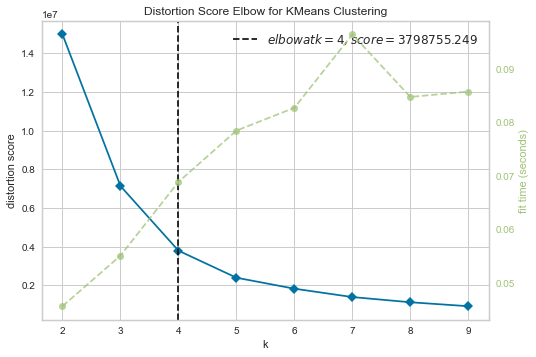

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc585a666d8>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [224]:
df_grouped_clustering, y = load_nfl()

kelbow_visualizer(KMeans(random_state=0), df_grouped_clustering, k=(2,10))

### By running the elbow method, we could see that the optimal number of clusters is 4.

<a id='item52'></a>
## 5.2 K-mean clustering

In [230]:
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

kmeans.labels_[0:10]

array([1, 0, 2, 1, 2, 1, 0, 2, 2, 1], dtype=int32)

In [231]:
# add clustering labels
df.insert(0, 'Cluster Labels', kmeans.labels_)

austin_merged = neigh

# merge to add latitude/longitude for each neighborhood
df = df.join(austin_merged.set_index('name'), on='name')

#austin_merged.head()
df.head()

Cluster Labels                 name price-binned      partI  \
0               1  University of Texas    Low price       Safe   
1               0       Georgian Acres    Low price  Mid. Safe   
2               2        Windsor Hills    Low price       Safe   
3               1     University Hills    Low price       Safe   
4               2       Coronado Hills    Low price       Safe   

            Venue Claster                                           geometry  \
0  Coffee and food venues  MULTIPOLYGON (((-97.73898 30.28361, -97.73963 ...   
1  Food trucks and hotels  MULTIPOLYGON (((-97.68801 30.35822, -97.68963 ...   
2     Multi-social venues  MULTIPOLYGON (((-97.67739 30.35166, -97.67899 ...   
3  Coffee and food venues  MULTIPOLYGON (((-97.67320 30.32560, -97.67171 ...   
4     Multi-social venues  MULTIPOLYGON (((-97.68630 30.33258, -97.68348 ...   

    latitude  longtitude  
0  30.285014  -97.733287  
1  30.351242  -97.699545  
2  30.363869  -97.676359  
3  30.313872  -97.669963  
4  30.326105  -97.684967

In [232]:
df.dtypes

Cluster Labels       int32
name                object
price-binned      category
partI             category
Venue Claster       object
geometry          geometry
latitude           float64
longtitude         float64
dtype: object

In [239]:
df['Cluster Labels'].value_counts()

2    19
1    19
3    18
0    14
Name: Cluster Labels, dtype: int64

In [242]:
df['name'].loc[df['Cluster Labels'] == 0]

1        Georgian Acres
6        Heritage Hills
16      Pleasant Valley
17           St. John's
26         St. Edward's
30          West Campus
32              Hancock
33         Barton Hills
38          South Lamar
45               Zilker
50           Montopolis
51    East Cesar Chavez
59        Bouldin Creek
68              Mueller
Name: name, dtype: object

In [243]:
df['name'].loc[df['Cluster Labels'] == 1]

0     University of Texas
3        University Hills
5            North Austin
9                 Gateway
11              West Gate
13           Windsor Park
14      North Shoal Creek
20           North Burnet
23              Hyde Park
24               Highland
25                 Dawson
27           North Campus
61               Rosewood
62               Downtown
63              Allandale
64            East Austin
65              Tarrytown
67               Chestnut
69       Wilshire/Delwood
Name: name, dtype: object

In [244]:
df['name'].loc[df['Cluster Labels'] == 2]

2        Windsor Hills
4       Coronado Hills
7               Wooten
8          North Lamar
10                 MLK
12       Franklin Park
15           Riverside
18         Oak Springs
19       West Congress
21         Parker Lane
22             Galindo
28          Sweetbriar
37       Garrison Park
40           Southeast
47           Crestview
52      South Manchaca
54    Johnston Terrace
58            Rosedale
66             Govalle
Name: name, dtype: object

In [245]:
df['name'].loc[df['Cluster Labels'] == 3]

29                        Triangle State
31                             Blackland
34                             Brentwood
35                              Oak Hill
36                      Pecan-Springdale
39          Rogers-Washington-Holy Cross
41                              Ridgelea
42                           Old Enfield
43                           Clarksville
44                        Travis Heights
46                              McKinney
48                   North Loop/Ridgetop
49                         East Congress
53    Pemberton Heights and Bryker Woods
55                       Oakmont Heights
56                            Cherrywood
57                               MLK-183
60                                 Holly
Name: name, dtype: object

<a id='item53'></a>
## 5.3 Examine clusters
### The map consists of circle markers of a different color for other clusters. Popup label has information about neighborhood name, price level, crime rate, and cluster venue name.

In [233]:
map_clusters = folium.Map(location=[30.2711286, -97.7436995], zoom_start=12)

map_clusters.choropleth(
    geo_data=r'austin.geojson',
    name='Rent',
    data=rent_poligon,
    columns=['name','price'],
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Rent price per house',
    key_on= 'feature.properties.name',
    highlight=True
)  


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []

for lat, lon, ngh, cluster, price, offenses, venues in zip(df['latitude'],
                            df['longtitude'],
                            df['name'],
                            df['Cluster Labels'],
                            df['price-binned'],
                            df['partI'],
                            df['Venue Claster']):
    label = folium.Popup(str(ngh)+', Cluster '+
                         str(cluster+1)+', '+
                         str(price)+', '+
                         str(offenses)+', '+
                         str(venues),
                         parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)


folium.LayerControl().add_to(map_clusters)
       
map_clusters

In [247]:
Cluster1 = df.loc[df['Cluster Labels'] == 0].drop(['geometry', 'latitude', 'longtitude'], 1)
Cluster1

Cluster Labels               name  price-binned      partI  \
1                0     Georgian Acres     Low price  Mid. Safe   
6                0     Heritage Hills     Low price  Mid. Safe   
16               0    Pleasant Valley     Low price  Mid. Safe   
17               0         St. John's     Low price  Mid. Safe   
26               0       St. Edward's     Low price  Mid. Safe   
30               0        West Campus  Medium price  Mid. Safe   
32               0            Hancock  Medium price  Mid. Safe   
33               0       Barton Hills  Medium price  Mid. Safe   
38               0        South Lamar  Medium price  Mid. Safe   
45               0             Zilker  Medium price  Mid. Safe   
50               0         Montopolis  Medium price  Mid. Safe   
51               0  East Cesar Chavez  Medium price  Mid. Safe   
59               0      Bouldin Creek  Medium price  Mid. Safe   
68               0            Mueller    High price  Mid. Safe   

             Venue Claster  
1   Food trucks and hotels  
6   Coffee and food venues  
16  Coffee and food venues  
17  Food trucks and hotels  
26  Coffee and food venues  
30  Coffee and food venues  
32  Coffee and food venues  
33  Coffee and food venues  
38  Coffee and food venues  
45  Coffee and food venues  
50  Food trucks and hotels  
51  Coffee and food venues  
59  Coffee and food venues  
68  Coffee and food venues

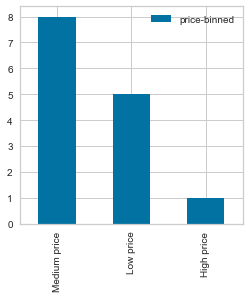

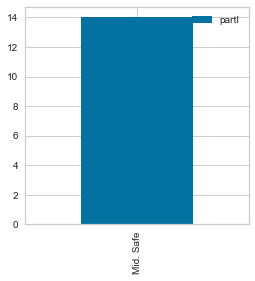

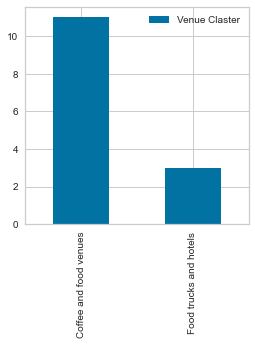

In [263]:
Cluster1['price-binned'].value_counts().to_frame().plot(kind='bar', figsize=(4,4))
c1p = Cluster1['partI'].value_counts().to_frame()
c1p.loc[c1p['partI'] > 0].plot(kind='bar',figsize=(4,4))
Cluster1['Venue Claster'].value_counts().to_frame().plot(kind='bar',figsize=(4,4))

## Cluster #1 has medium safe neighborhoods, a variety of rent prices, coffee, food venues, and three food trucks and hotel venues.

In [249]:
Cluster2 = df.loc[df['Cluster Labels'] == 1].drop(['geometry', 'latitude', 'longtitude'], 1)
Cluster2

Cluster Labels                 name price-binned                partI  \
0                1  University of Texas    Low price                 Safe   
3                1     University Hills    Low price                 Safe   
5                1         North Austin    Low price       Mid. Dangerous   
9                1              Gateway    Low price                 Safe   
11               1            West Gate    Low price                 Safe   
13               1         Windsor Park    Low price        Medium crimes   
14               1    North Shoal Creek    Low price                 Safe   
20               1         North Burnet    Low price        Medium crimes   
23               1            Hyde Park    Low price                 Safe   
24               1             Highland    Low price                 Safe   
25               1               Dawson    Low price                 Safe   
27               1         North Campus    Low price                 Safe   
61               1             Rosewood   High price                 Safe   
62               1             Downtown   High price  Extremely Dangerous   
63               1            Allandale   High price                 Safe   
64               1          East Austin   High price                 Safe   
65               1            Tarrytown   High price                 Safe   
67               1             Chestnut   High price                 Safe   
69               1     Wilshire/Delwood   High price                 Safe   

             Venue Claster  
0   Coffee and food venues  
3   Coffee and food venues  
5   Coffee and food venues  
9   Coffee and food venues  
11  Coffee and food venues  
13  Coffee and food venues  
14  Coffee and food venues  
20  Coffee and food venues  
23  Coffee and food venues  
24  Coffee and food venues  
25  Coffee and food venues  
27  Coffee and food venues  
61  Coffee and food venues  
62  Coffee and food venues  
63  Coffee and food venues  
64  Coffee and food venues  
65  Coffee and food venues  
67  Coffee and food venues  
69  Coffee and food venues

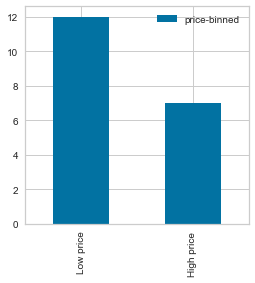

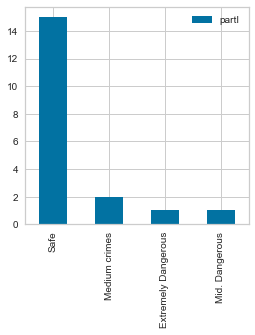

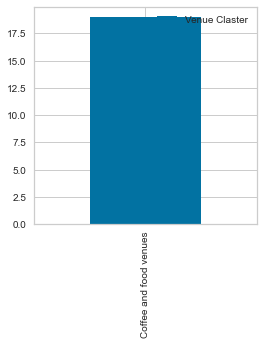

In [270]:
c2pb = Cluster2['price-binned'].value_counts().to_frame()
c2pb.loc[c2pb['price-binned'] > 0].plot(kind='bar', figsize=(4,4))
c2p = Cluster2['partI'].value_counts().to_frame()
c2p.loc[c2p['partI'] > 0].plot(kind='bar',figsize=(4,4))
Cluster2['Venue Claster'].value_counts().to_frame().plot(kind='bar',figsize=(4,4))

## Cluster #2 generally has safe neighborhoods, but you need to be careful choosing this because it consists of extremely dangerous, medium dangerous, and an average rate of crimes; rent prices are either low or high; you could find coffee and food venues.

In [251]:
Cluster3 = df.loc[df['Cluster Labels'] == 2].drop(['geometry', 'latitude', 'longtitude'], 1)
Cluster3

Cluster Labels              name  price-binned          partI  \
2                2     Windsor Hills     Low price           Safe   
4                2    Coronado Hills     Low price           Safe   
7                2            Wooten     Low price           Safe   
8                2       North Lamar     Low price           Safe   
10               2               MLK     Low price           Safe   
12               2     Franklin Park     Low price      Mid. Safe   
15               2         Riverside     Low price  Medium crimes   
18               2       Oak Springs     Low price           Safe   
19               2     West Congress     Low price           Safe   
21               2       Parker Lane     Low price      Mid. Safe   
22               2           Galindo     Low price           Safe   
28               2        Sweetbriar     Low price           Safe   
37               2     Garrison Park  Medium price           Safe   
40               2         Southeast  Medium price           Safe   
47               2         Crestview  Medium price           Safe   
52               2    South Manchaca  Medium price           Safe   
54               2  Johnston Terrace  Medium price           Safe   
58               2          Rosedale  Medium price           Safe   
66               2           Govalle    High price           Safe   

          Venue Claster  
2   Multi-social venues  
4   Multi-social venues  
7   Multi-social venues  
8   Multi-social venues  
10            Park zone  
12  Multi-social venues  
15  Multi-social venues  
18  Multi-social venues  
19  Multi-social venues  
21  Multi-social venues  
22  Multi-social venues  
28  Multi-social venues  
37  Multi-social venues  
40  Multi-social venues  
47  Multi-social venues  
52  Multi-social venues  
54  Multi-social venues  
58  Multi-social venues  
66  Multi-social venues

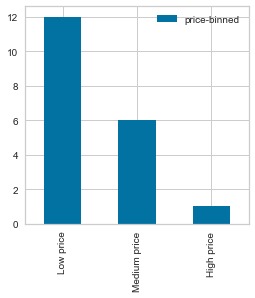

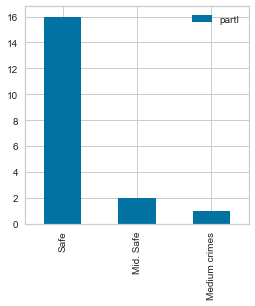

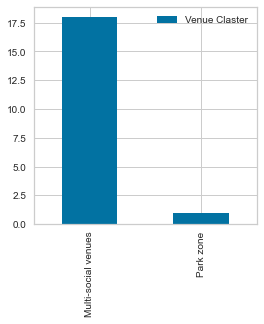

In [269]:
c3pb = Cluster3['price-binned'].value_counts().to_frame()
c3pb.loc[c3pb['price-binned'] > 0].plot(kind='bar', figsize=(4,4))
c3p = Cluster3['partI'].value_counts().to_frame()
c3p.loc[c3p['partI'] > 0].plot(kind='bar',figsize=(4,4))
Cluster3['Venue Claster'].value_counts().to_frame().plot(kind='bar',figsize=(4,4))

## Cluster #3 has multi-social venues, 85 percent of safe neighborhoods, a variety of rent prices, multi-social venues, and park zone.

In [253]:
Cluster4 = df.loc[df['Cluster Labels'] == 3].drop(['geometry', 'latitude', 'longtitude'], 1)
Cluster4.head()

Cluster Labels              name  price-binned          partI  \
29               3    Triangle State  Medium price           Safe   
31               3         Blackland  Medium price           Safe   
34               3         Brentwood  Medium price           Safe   
35               3          Oak Hill  Medium price  Medium crimes   
36               3  Pecan-Springdale  Medium price           Safe   

             Venue Claster  
29  Coffee and food venues  
31  Coffee and food venues  
34  Coffee and food venues  
35  Coffee and food venues  
36               Park zone

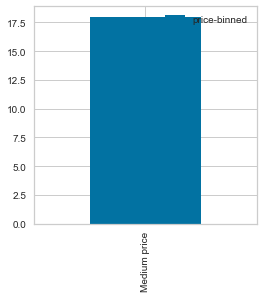

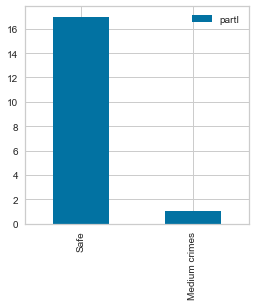

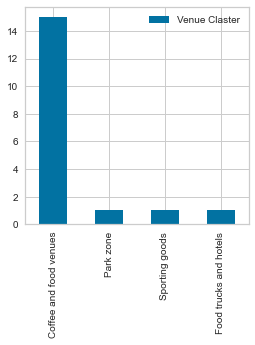

In [271]:
c4pb = Cluster4['price-binned'].value_counts().to_frame()
c4pb.loc[c4pb['price-binned'] > 0].plot(kind='bar', figsize=(4,4))
c4p = Cluster4['partI'].value_counts().to_frame()
c4p.loc[c4p['partI'] > 0].plot(kind='bar',figsize=(4,4))
Cluster4['Venue Claster'].value_counts().to_frame().plot(kind='bar',figsize=(4,4))

## Cluster #4 has a medium price property, 95 percent safe neighborhoods, 83 percent of coffee and food venues.

_________
### The next map will help to navigate between clusters. A person could choose a cluster that he likes and see every neighborhood belongs to that cluster.

In [278]:
clusters = folium.Map(location=[30.2711286, -97.7436995], zoom_start=12)

clusters.choropleth(
    geo_data=r'austin.geojson',
    name='Cluster 1',
    data=Cluster1,
    columns=['name','Cluster Labels'],
    fill_color='YlGn',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='1',
    key_on= 'feature.properties.name',
    highlight=True
)

clusters.choropleth(
    geo_data=r'austin.geojson',
    name='Cluster 2',
    data=Cluster2,
    columns=['name','Cluster Labels'],
    fill_color='YlGn',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='2',
    key_on= 'feature.properties.name',
    highlight=True
)  

clusters.choropleth(
    geo_data=r'austin.geojson',
    name='Cluster 3',
    data=Cluster3,
    columns=['name','Cluster Labels'],
    fill_color='YlGn',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='3',
    key_on= 'feature.properties.name',
    highlight=True
)

clusters.choropleth(
    geo_data=r'austin.geojson',
    name='Cluster 4',
    data=Cluster4,
    columns=['name','Cluster Labels'],
    fill_color='YlGn',
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='4',
    key_on= 'feature.properties.name',
    highlight=True
)


for lat, lon, ngh in zip(df['latitude'],
                        df['longtitude'],
                        df['name']):
    label = folium.Popup(str(ngh),
                         parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        fill=True,
        fill_opacity=1).add_to(clusters)


folium.LayerControl().add_to(clusters)
       
clusters